# Springboard Capstone 2: Time Series
## Covid-19 Wastewater Surveillance Prediction
### Author: Nantawat Samermit

## Executive Summary

### Problem:
The Sars-CoV-19 or 'Covid-19' virus is an ongoing pandemic. Businesses and communities are being affected with each wave and each new variant. Wastewater surveillance is a non-invasive way to measure mRNA concentrations of the virus.

### Exploratory Research Question:
Can we use the viral concentration surveilled from wastewater to forecast a trend of Covid-19 infections in a community?


### Methods
    1. Using time-series models to forecast the concentration of Covid-19 mRNA in surveilled wastewater.

### Results
    1. Time series using AR models with differencing can yield a forecast of that trend.

### Implications
I believe that using a forecast of Covid-19 mRNA concentration in wastewater could be used as an indicator to the presence of Covid-19 in that area. However this is with the following assumption:
1. Wastewater will be continuously surveilled
2. Viral shedding persists into wastewater with any future dominant variants

### Dependencies

In [1]:
#import relevant modules for data wrangling - keep on adding as needed
import pandas as pd
import json, requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#for web-scraping in Data Wrangling Module
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

#for saving pickle files in Data Wrangling Module
import pickle


#For Preprocessing
from sklearn import preprocessing
import statsmodels.api as sm
import pmdarima as pm
import random as random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as tsaplots

from statsmodels.tsa.arima_model import ARIMA
# Silencing the ARIMA deprecation warning
import warnings

import re


# Methods defined for this project

In [109]:
#I could save this as its own .py package and import it, but I wanted to showcase it. 

def get_sources(source_list):
    '''
    this function takes a list of urls, ID's their format, requests dataset from source,
    converts data into a dataframe, then saves it as a pickled file.
    '''
    for counter, source in enumerate(source_list):
        name = str(counter) + '_df.pkl'

        if source.endswith('.json'):
            response = requests.get(source)
            data = response.json()
            json_df = pd.DataFrame(data)            
            json_df.to_pickle(name)
            
        
        elif source.endswith('.csv'):
            csv = pd.read_csv(source, engine='python')
            csv.to_pickle(name)
            
        else:
            response = requests.get(source, allow_redirects=True)
            with open('excel_data.xlsx', 'wb') as file:
                file.write(response.content)
            
            #using pd.read_excel on a multi-spreadsheet xls yields a dictionary
            excel_dict = pd.read_excel('excel_data.xlsx', sheet_name=None)
            name = str(counter) + '_df.pkl'
            #can ID sheetnames by evaluating keys
            #print(excel_dict.keys())
            if len(excel_dict.keys()) > 1:
                print('There are more than one sheet in this .csv file.','\n',
                      source, '\n', excel_dict.keys())
                myInput = input('Which of these sheets do  you want to use?')
                #print(myInput)
                excel_specified_sheet = excel_dict[myInput]
                excel_specified_sheet.to_pickle(name)
            else:
                excel_dict.to_pickle(name)
            
        print(name,' created using this source', source)

def blank_check(df):
    ''' A method to check my column cells from a pandas DataFrame for whitespace blanks.'''
    return dict(zip(df.columns, [(df[x] == '').sum() for x in df.columns]))        

def conversion(df, conversion_list):
    '''Method to convert my features into their appropriate datatypes'''
    for list in conversion_list:
        for col in list:
            if col in datetime_list:
                df[col] = pd.to_datetime(test[col], infer_datetime_format=True)
            if col in category_list:
                df[col] = df[col].astype('category')
            if col in float64_list:
                df[col] = df[col].astype('float64')
                
def county_ADF(df: pd.DataFrame, feature):
    '''
    A method to extract the Augmented Dicky-Fuller test values from county level data
    Params:
    df - (pd.DataFrame) with 'County' column
    feature -  (string) - the name of the feature column to test for ADF
    Returns a dictionary with:
    County -  (string) the name of the county
    ADF - (tuple) the test-statistic and p-value of that county level data
    '''
    adf_dict = {}
    for county in df.County.unique():
        adf_dict[county] = pd.DataFrame(df.loc[df['County']==county, 
                                               feature]
                                          .drop_duplicates())
        
        
    #print(adf_dict.keys())
    county_ADF = {}
    for county, df in adf_dict.items():
        adf = sm.tsa.stattools.adfuller(df[feature])
        county_ADF[county] = {'test-statistic': adf[0], 'p-value':adf[1]}
    return county_ADF


def county_ACF(df: pd.DataFrame, county: pd.Series, wanted_feature: str):
    if wanted_feature == None:
        wanted_feature = 'normalized_concentration_rolling_average'
    else: 
        #wanted_feature = "'" + wanted_feature + "'"
        print(wanted_feature)
    data = pd.DataFrame(df.loc[df.County==county, wanted_feature].drop_duplicates())
    #Setting up the figure and axes
    fig, axes = plt.subplots(3, 2, sharex=False)
    fig.dpi==120
    
    # Original Series
    sns.lineplot(data=data, x= data.index, 
             y = data[wanted_feature], 
             ax=axes[0,0])
    axes[0, 0].set_title(county+' County Original Series')
    plot_acf(data[wanted_feature], ax=axes[0, 1])

    # 1st Differencing
    sns.lineplot(data=data, x= data.index, 
             y = data[wanted_feature].diff(), 
             ax=axes[1,0])
    axes[1, 0].set_title(county+' County 1st Order Differencing')
    plot_acf(data[wanted_feature].diff().dropna(), ax=axes[1, 1])

    # 2nd Differencing
    sns.lineplot(data=data, x= data.index, 
             y = data[wanted_feature].diff().diff(), ax=axes[2,0])
    axes[2, 0].set_title(county+' County 2nd Order Differencing')
    plot_acf(data[wanted_feature].diff().diff().dropna(), ax=axes[2, 1])

    plt.tight_layout()
    plt.show()

def counties_ACF(df: pd.DataFrame, order: int):
    '''
    A method to plot side-by-side a lineplot and the ACF for all the counties in the dataframe.
    Parameters:
    df: Pandas DataFrame with a County column
    order: the lag value, integer from 0 onwards
    '''
    county_list = []
    county_dict = {}
    wanted_feature = 'normalized_concentration_rolling_average'
    yaxislabel = 'norm. concentration'

    for County in df.County.unique():
        data = pd.DataFrame(df.loc[df.County==County, wanted_feature].drop_duplicates())
        county_dict[County] = data

    fig, axes = plt.subplots(len(county_dict.keys()), 2, sharey=False)

    for counter, (county, df) in enumerate(county_dict.items()):
        if order == 0: 
            axes[counter,0].set_title(county + ' county Original Series')
            sns.lineplot(data=df, x=df.index, y=df[wanted_feature], 
                         ax=axes[counter,0])
            plot_acf(df[wanted_feature], ax=axes[counter, 1])
            
        else: 
            axes[counter,0].set_title(county  + ' county '
                                      + str(order)
                                      + ' order difference')
            
            #This gets really redundant, but I can't find a way to programtically add .diff() for stipulated order
            if order == 1:
                sns.lineplot(data=df, x=df.index, 
                             y=df[wanted_feature].diff(), ax=axes[counter,0])
                plot_acf(df[wanted_feature].diff().dropna(), ax=axes[counter, 1])
            if order == 2:
                sns.lineplot(data=df, x=df.index, 
                             y=df[wanted_feature].diff().diff(), ax=axes[counter,0])
                plot_acf(df[wanted_feature].diff().diff().dropna(), ax=axes[counter, 1])
            if order == 3:
                sns.lineplot(data=df, x=df.index, 
                             y=df[wanted_feature].diff().diff().diff(), ax=axes[counter,0])
                plot_acf(df[wanted_feature].diff().diff().diff().dropna(), ax=axes[counter, 1])
            if order > 3:
                print('No way Jose, quit while you are ahead')
                
        
        axes[counter,0].set(ylabel=yaxislabel)

    plt.tight_layout()
    plt.show()
    
def County_modelling(county: str, dict_ARIMA: dict, 
                    dict_counties: dict, feature: str, test_size: float,
                    print_stats: bool):
    '''
    A method to do forecast a feature using the ARIMA time-series model.
    Parameters:
    county: (string), the county which we want to forecast
    dict_ARIMA: (dict) holds the best ARIMA model as calculated by auto_arima
    dict_counties: (dict) holds the dataframe with the feature we will be forecasting
    feature: (string) the feature we want to use to do the forecasting
    test_size: (float) the decimal representing the percentage of the test partition
    print_stats: (boolean) a flag to print the accuracy metrics of the ARIMA model
    '''
    if feature == None or feature == '':
        feature_ = 'normalized_concentration_rolling_average'
    else: feature_ = feature
    for a_county, best_model in dict_ARIMA.items():
        
        #print('dict_ARIMA flag0') #leave for debug purposes

        for county_, df in dict_counties.items():
            
            #print('dict_counties flag1') #leave for debug purposes
            
            #A filter to ensure that the county parameter matches that in our two supplied dicts
            #Once again, this is not a good way to partition a time-series. Deprecate
            if county_ == county and a_county == county_:
                
                #print('county_ == county flag 2') #leave for debug purposes
                #print(county_, df.shape)

                #Defining the test train partition using the shape of the dataframe
                #whatever is being multiplied to .shape[0] is the test size percentage
                
                test_slice = round(df.shape[0]*test_size)
                df_slice = int(df.shape[0]) - test_slice

                
                
                
    
    #convert best_model into a string, and then slice it to extract needed p,d,q values
    text = str(best_model)
    x = text[6:13] #this is the slice of the (p,d,q) in best_model
    
    #Note there are 7 items in x, and the 1st, 3rd, and 5th items are the p,d,q values
    p,d,q = int(x[1]), int(x[3]), int(x[5])
    
    #partitions should be done based on how many lags are used in the model.
    train = df[:-2]
    test = df[-2:]

    #Create the ARIMA model using train and the auto_arima p,d,q values
    model = ARIMA(train, order=(p,d,q))
    fitted = model.fit(disp=-1)

    #forecast with 95% confidence
    fc, se, conf = fitted.forecast(len(test), alpha=0.05)

    #make a panda series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    #Plot all the counties 

    plt.figure(figsize=(12,5), dpi=100)

    plt.plot(train, label='Training')
    plt.plot(test, label='Actual')
    plt.plot(fc_series, label='Forecast')
    plt.fill_between(lower_series.index, lower_series, 
                     upper_series, color='k', 
                     alpha=0.15)

    if feature == None or feature == '': 
        plt.title(f'{p},{d},{q} ARIMA Forecast Vs. Actuals: ' + str(county))    
    else: 
        plt.title(str(feature) + f' {p},{d},{q} ARIMA Forecast Vs. Actuals: ' + str(county))
    plt.legend(loc='upper left')
    plt.show()

    #Defining my accuracy metrics

    actual = test[feature_]

    #MAPE - Mean Absolute Percentage Errors
    #print(fc_series.values,'\n', test.values)
    mape = np.mean(np.abs(fc_series.values - actual.values)/np.abs(actual.values)) 

    #MAE - Mean Absolute Error
    mae = np.mean((fc_series.values - actual.values)/actual.values)

    #Mean Error
    me = np.mean(fc_series.values - actual.values)

    #Correlation between actual and forecast
    #print(fc_series, fc_series.shape, '\n', actual, actual.shape)
    corr = np.corrcoef(fc_series.values, actual.values)[0,1]

    #Min-Max Error
    mins = np.amin(np.hstack([fc_series.values[:,None],
                              actual.values[:,None]]), axis=1)

    maxs = np.amax(np.hstack([fc_series.values[:,None],
                              actual.values[:,None]]), axis=1)

    minmax = 1 - np.mean(mins/maxs)

    if print_stats == True:
        print('MAPE: ', mape, '\nMAE: ', mae, '\nME: ', me,
              '\nCorrelation: ', corr, '\nMin-Max: ', minmax)
        
def County_forecast(county: str, dict_ARIMA: dict, 
                    dict_counties: dict, feature: str, 
                    test_size: float, suppress_plot: bool):
    '''
    A method to do forecast a feature using the ARIMA time-series model.
    Parameters:
    county: (string), the county which we want to forecast
    dict_ARIMA: (dict) holds the best ARIMA model as calculated by auto_arima
    dict_counties: (dict) holds the dataframe with the feature we will be forecasting
    feature: (string) the feature we want to use to do the forecasting
    test_size: (float) the decimal representing the percentage of the test partition
    '''
    if feature == None or feature == '':
        feature_ = 'normalized_concentration_rolling_average'
    else: feature_ = feature
    for a_county, best_model in dict_ARIMA.items():

        for county_, df in dict_counties.items():
            
            #A filter to ensure that the county parameter matches that in our two supplied dicts
            if county_ == county and a_county == county_:

                #convert best_model into a string, and then slice it to extract needed p,d,q values
                text = str(best_model)
                x = text[6:13] #this is the slice of the (p,d,q) in best_model
                
                data = df
                #Note there are 7 items in x, and the 1st, 3rd, and 5th items are the p,d,q values
    p,d,q = int(x[1]), int(x[3]), int(x[5])

    


    #Create the ARIMA model using train and the auto_arima p,d,q values
    model = ARIMA(data, order=(p,d,q))
    fitted = model.fit(disp=-1)
    print(fitted)

    
    #forecast
    n_periods = 2
    index_of_fc = pd.date_range(df.index[-1], periods=n_periods, freq='W')

    #setting the param in forecast as n_periods means we are asking for out of sample forecasts
    #n_periods must match with th length we use in our plotting series in index=
    forecast, se, confint = fitted.forecast(n_periods, alpha=0.05)
    

    #forecast with 95% confidence
    #fc, se, conf = fitted.forecast(len(test), alpha=0.05)

    #make series for plotting purpose
    forecast_series = pd.Series(forecast, index=index_of_fc)
    lower_series = pd.Series(confint[:,0], index=index_of_fc)
    upper_series = pd.Series(confint[:,1], index=index_of_fc)

    if suppress_plot==False:
       #Plot all the counties 
        plt.figure(figsize=(12,5), dpi=100)
        plt.plot(data)
        plt.plot(forecast_series, label='Forecast', color='orange')
        plt.fill_between(lower_series.index, 
                         lower_series, 
                         upper_series, 
                         color='k', 
                         alpha=0.15)

        if feature == None or feature == '': 
            plt.title(f'{p},{d},{q} ARIMA Forecast: ' + str(county))    
        else: 
            plt.title(str(feature) + f' {p},{d},{q} ARIMA Forecast: ' + str(county))
        plt.legend(loc='upper left')
        plt.show()  
    else:
        print(fitted.summary())

def ARIMA_diagnostics(county: str, dictionary: dict):
    for County,Model in dictionary.items():
        if County==county:
            Model.plot_diagnostics()
    plt.show()

# Data Scraping (Unit 7.2)
I'll be scraping three datasets. 

The first is from the Cambridge MA wastewater data archive. It is listed as JSON, which I will convert to a pandas DataFrame. 

The URL is here: 'https://data.cambridgema.gov/resource/ayt4-g2ye.json'


The second dataset is from Massachusetts Department of Health. 

The URL is here: 'https://www.mass.gov/doc/covid-19-raw-data-june-15-2021/download'

The third dataset is from Biobot's Github: https://github.com/biobotanalytics/covid19-wastewater-data/blob/master/wastewater_by_county.csv

I downloaded the third dataset from Github and added it to the Biobot Data folder.

### Notes regarding Massachusetts Data
After some attempts, it seems the Massachusetts dataset is a multi-page csv, and it isn't easily accessible.

I will have to use BeautifulSoup to isolate the link to the excel file.

In [3]:
# Use BS to identify/isolate the html "class" pointing to the href of the .xls 
#class and "ma__download-link__file-link" was identified by inspecting the page's elements in chrome
source = requests.get("https://www.mass.gov/doc/covid-19-raw-data-july-29-2021")
BeautifulSoup(source.content).find("a", {"class":"ma__download-link__file-link"}).get("href")

'/doc/covid-19-raw-data-july-29-2021/download'

In [4]:
sources = ['https://data.cambridgema.gov/resource/ayt4-g2ye.json', 
           'https://www.mass.gov/doc/covid-19-raw-data-july-29-2021/download',
           'Biobot Data/wastewater_by_county.csv' 
          ]

get_sources(sources)

0_df.pkl  created using this source https://data.cambridgema.gov/resource/ayt4-g2ye.json
There are more than one sheet in this .csv file. 
 https://www.mass.gov/doc/covid-19-raw-data-july-29-2021/download 
 dict_keys(['Data Documentation', 'Weekly_Town_Reference', 'Age Means Last2Weeks', 'AgeLast2Weeks', 'Cases (Report Date)', 'CasesbyAge', 'CasesByDate (Test Date)', 'CasesByDate_Probable', 'County_Daily', 'County_Weekly', 'CountyDeaths', 'DateofDeath', 'DeathsReported (Report Date)', 'DeathCharacteristics', 'HigherEd_CasesandTests', 'HospBedAvailable-Regional', 'HospBed-Hospital COVID Census', 'Hospitalization from Hospitals', 'LTC Facilities', 'RaceEthnicityLast2Weeks', 'SexLast2Weeks', 'Testing2 (Report Date)', 'TestingByDate (Test Date)', 'TestingPosByAge', 'Weekly_City_Town', 'Weekly_Statewide', 'Clusters', 'Isolation and Quarantine', 'Contact Tracing', 'CTC workforce', 'Counts by Specimen Date (Sero)'])
Which of these sheets do  you want to use?Weekly_City_Town
1_df.pkl  created 

### Use pickle to confirm the saved files can be loaded in Jupyter


In [5]:
with open('0_df.pkl', 'rb') as f:
    Cambridge_df = pickle.load(f)
    
with open('1_df.pkl', 'rb') as f:
    Mass_df = pickle.load(f)

with open('2_df.pkl', 'rb') as f:
    Biobot_df = pickle.load(f)

In [6]:
#testing all three dataframes
Cambridge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date                          328 non-null    object
 1   mwra_concentration            328 non-null    object
 2   mwra_7dayaverage              328 non-null    object
 3   concentration_mid_cambridge   328 non-null    object
 4   concentration_east_cambridge  328 non-null    object
 5   concentration_cambridgeport   328 non-null    object
 6   concentration_north_west      328 non-null    object
 7   highci_mid_cambridge          328 non-null    object
 8   highci_east_cambridge         328 non-null    object
 9   highci_cambridgeport          328 non-null    object
 10  highci_north_west_cambridge   328 non-null    object
 11  lowci_mid_cambridge           328 non-null    object
 12  lowci_east_cambridge          328 non-null    object
 13  lowci_cambridgeport 

In [7]:
Mass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11296 entries, 0 to 11295
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   City/Town                   11296 non-null  object        
 1   County                      11296 non-null  object        
 2   Population                  11296 non-null  object        
 3   Total Case Counts           11296 non-null  object        
 4   Two Week Case Counts        11296 non-null  object        
 5   Average Daily Rate          11296 non-null  object        
 6   Color                       9495 non-null   object        
 7   Change in Last Week         11296 non-null  object        
 8   Total Tests                 11296 non-null  int64         
 9   Total Tests Last Two Weeks  11295 non-null  float64       
 10  Total Positive Tests        11295 non-null  float64       
 11  Percent Positivity          11295 non-null  object    

In [8]:
Biobot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   sampling_week                             1267 non-null   object 
 1   normalized_concentration_rolling_average  1267 non-null   float64
 2   population                                1267 non-null   object 
 3   region                                    1267 non-null   object 
 4   state                                     1267 non-null   object 
 5   county_fips_code                          1267 non-null   int64  
 6   county_name                               1267 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 69.4+ KB


# Data Wrangling (Unit 7.2)
Explore the dataset. Understand the datatypes for the various columns, and confirm that there are no missing values.

## Cambridge Data

In [9]:
Cambridge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date                          328 non-null    object
 1   mwra_concentration            328 non-null    object
 2   mwra_7dayaverage              328 non-null    object
 3   concentration_mid_cambridge   328 non-null    object
 4   concentration_east_cambridge  328 non-null    object
 5   concentration_cambridgeport   328 non-null    object
 6   concentration_north_west      328 non-null    object
 7   highci_mid_cambridge          328 non-null    object
 8   highci_east_cambridge         328 non-null    object
 9   highci_cambridgeport          328 non-null    object
 10  highci_north_west_cambridge   328 non-null    object
 11  lowci_mid_cambridge           328 non-null    object
 12  lowci_east_cambridge          328 non-null    object
 13  lowci_cambridgeport 

In [10]:
Cambridge_df.describe()

,date,mwra_concentration,mwra_7dayaverage,concentration_mid_cambridge,concentration_east_cambridge,concentration_cambridgeport,concentration_north_west,highci_mid_cambridge,highci_east_cambridge,highci_cambridgeport,highci_north_west_cambridge,lowci_mid_cambridge,lowci_east_cambridge,lowci_cambridgeport,lowci_north_west_cambridge
count,328,328,328,328,328,328,328,328,328,328,328,328,328,328,328
unique,328,253,239,33,39,29,36,33,39,29,36,33,39,29,36
top,2021-07-16T00:00:00.000,,20,,,,,,,,,,,,
freq,1,12,6,289,287,292,288,289,287,292,288,289,287,292,288


## Features observations:
1. All the features pf Cambridge_df are object dtypes.
2. describe() states they (15 features) are all non-null values. Let's confirm that.

In [11]:
#This confirms that none of the features contain null values. 
Cambridge_df.isnull().sum()

date                            0
mwra_concentration              0
mwra_7dayaverage                0
concentration_mid_cambridge     0
concentration_east_cambridge    0
concentration_cambridgeport     0
concentration_north_west        0
highci_mid_cambridge            0
highci_east_cambridge           0
highci_cambridgeport            0
highci_north_west_cambridge     0
lowci_mid_cambridge             0
lowci_east_cambridge            0
lowci_cambridgeport             0
lowci_north_west_cambridge      0
dtype: int64

## What I've learned from this section:
Even though .isnull().sum() reports no null value, sometimes it's not that easy. In data, there is a concept of 'missingness' that I need to be aware of. Here is my workthrough to investigate for 'missingness'.

In [12]:
#This will show that although isnull().sum() returns 0 null values, the cells look blank!
Cambridge_df.head(5)

,date,mwra_concentration,mwra_7dayaverage,concentration_mid_cambridge,concentration_east_cambridge,concentration_cambridgeport,concentration_north_west,highci_mid_cambridge,highci_east_cambridge,highci_cambridgeport,highci_north_west_cambridge,lowci_mid_cambridge,lowci_east_cambridge,lowci_cambridgeport,lowci_north_west_cambridge
0,2020-10-01T00:00:00.000,,31,,,,,,,,,,,,
1,2020-10-02T00:00:00.000,34,31,,,,,,,,,,,,
2,2020-10-03T00:00:00.000,,31,,,,,,,,,,,,
3,2020-10-04T00:00:00.000,,31,,,,,,,,,,,,
4,2020-10-05T00:00:00.000,38,30,,,,,,,,,,,,


### This does not pass the stench test! mwra_concentration is not 100% non-null

In [13]:
#Check these blank cells to confirm they are 'filled' with whitespaces
Cambridge_df['mwra_concentration'][0] == ''

True

In [14]:
blank_check(Cambridge_df)

{'date': 0,
 'mwra_concentration': 12,
 'mwra_7dayaverage': 1,
 'concentration_mid_cambridge': 289,
 'concentration_east_cambridge': 287,
 'concentration_cambridgeport': 292,
 'concentration_north_west': 288,
 'highci_mid_cambridge': 289,
 'highci_east_cambridge': 287,
 'highci_cambridgeport': 292,
 'highci_north_west_cambridge': 288,
 'lowci_mid_cambridge': 289,
 'lowci_east_cambridge': 287,
 'lowci_cambridgeport': 292,
 'lowci_north_west_cambridge': 288}

### Looking at how many 'blank' whitespace cells those features have, I think it is prudent to drop them first

In [15]:
kept_features = ['date', 'mwra_concentration', 'mwra_7dayaverage']
Cambridge_df.drop(columns=Cambridge_df.columns.difference(kept_features), inplace=True)

#confirm those columns were dropped
Cambridge_df.describe()

,date,mwra_concentration,mwra_7dayaverage
count,328,328,328
unique,328,253,239
top,2021-07-16T00:00:00.000,,20
freq,1,12,6


In [16]:
#confirm how many blank cells to wrangle
blank_check(Cambridge_df)

{'date': 0, 'mwra_concentration': 12, 'mwra_7dayaverage': 1}

### At this point - Choose:
1. Drop those rows with blank columns
2. Impute them with something
    
    A: Can be the mwra_7dayaverage
    
    B: Can be a front-fill method    
    
    C:  Can be a back-fill method

In [17]:
#change 'date' feature into a datetime and assign to index
Cambridge_df.date = pd.to_datetime(Cambridge_df.date)
Cambridge_df.set_index('date', inplace=True)

In [18]:
#blank check before the whitespace replacement
blank_check(Cambridge_df)

{'mwra_concentration': 12, 'mwra_7dayaverage': 1}

In [19]:
#replace whitespace with NaN and check for an decrease in blank_check and increase in null
#The increase seen with .isnull() is due to us replacing '' with 
Cambridge_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [20]:
#blank check after whitespace replacement
blank_check(Cambridge_df)

{'mwra_concentration': 0, 'mwra_7dayaverage': 0}

In [21]:
Cambridge_df.isnull().sum()

mwra_concentration    12
mwra_7dayaverage       1
dtype: int64

#### This passes the stench test now, and we can easily deal with NaNs.

In [22]:
#replace mwra_7dayaverage NaNs with .replace() and frontfill method
Cambridge_df.mwra_7dayaverage.replace(np.nan, method='ffill', inplace=True)

#replace mwra_concentration NaNs with the given mwra_7dayaverage using .fillna()
Cambridge_df.mwra_concentration.fillna(Cambridge_df.mwra_7dayaverage, inplace=True)

Cambridge_df.isnull().sum()

mwra_concentration    0
mwra_7dayaverage      0
dtype: int64

In [23]:
Cambridge_cleaned = Cambridge_df.copy()

## Masschusetts Data

In [24]:
Mass_df.shape

(11296, 17)

In [25]:
Mass_df.columns

Index(['City/Town', 'County', 'Population', 'Total Case Counts',
       'Two Week Case Counts', 'Average Daily Rate', 'Color',
       'Change in Last Week', 'Total Tests', 'Total Tests Last Two Weeks',
       'Total Positive Tests', 'Percent Positivity', 'Change Since Last Week',
       'Testing Rate', 'Report Date', 'Start_Date', 'End_Date'],
      dtype='object')

In [26]:
Mass_df.County.value_counts()

Worcester     1920
Middlesex     1728
Essex         1088
Berkshire     1024
Norfolk        896
Plymouth       864
Franklin       832
Hampden        736
Bristol        640
Hampshire      640
Barnstable     480
Dukes          224
Suffolk        128
Nantucket       32
Statewide       32
Unknown         32
Name: County, dtype: int64

In [27]:
blank_check(Mass_df)

{'City/Town': 0,
 'County': 0,
 'Population': 0,
 'Total Case Counts': 0,
 'Two Week Case Counts': 0,
 'Average Daily Rate': 0,
 'Color': 0,
 'Change in Last Week': 0,
 'Total Tests': 0,
 'Total Tests Last Two Weeks': 0,
 'Total Positive Tests': 0,
 'Percent Positivity': 0,
 'Change Since Last Week': 0,
 'Testing Rate': 0,
 'Report Date': 0,
 'Start_Date': 0,
 'End_Date': 0}

#### I've decided to drop columns after I merge the Massachusetts and Biobot dfs.

## Biobot Data

In [28]:
Biobot_df.isnull().sum()

sampling_week                               0
normalized_concentration_rolling_average    0
population                                  0
region                                      0
state                                       0
county_fips_code                            0
county_name                                 0
dtype: int64

In [29]:
blank_check(Biobot_df)

{'sampling_week': 0,
 'normalized_concentration_rolling_average': 0,
 'population': 0,
 'region': 0,
 'state': 0,
 'county_fips_code': 0,
 'county_name': 0}

In [30]:
Biobot_df.shape

(1267, 7)

In [31]:
print(Biobot_df.state.value_counts(), Biobot_df.state.value_counts().sum())

MA    257
PA    184
CA    141
IN     81
TN     65
FL     59
NV     58
KY     55
CT     54
VA     49
OR     49
CO     48
NY     38
DE     36
IL     35
MN     30
NJ     28
Name: state, dtype: int64 1267


#### Biobot performed the most WBE surveillance in Massachusetts. Affirms my choice to use their dataset.

In [32]:
#Let's slice for MA data only
Biobot_MA = pd.DataFrame(Biobot_df.loc[Biobot_df.state=='MA'])
Biobot_MA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257 entries, 146 to 714
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   sampling_week                             257 non-null    object 
 1   normalized_concentration_rolling_average  257 non-null    float64
 2   population                                257 non-null    object 
 3   region                                    257 non-null    object 
 4   state                                     257 non-null    object 
 5   county_fips_code                          257 non-null    int64  
 6   county_name                               257 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 16.1+ KB


### Comparing Biobot's wastewater data to Cambridge

In [33]:
pd.DataFrame(Cambridge_df.loc['2020-Dec':'2021-Jan', ('mwra_concentration', 'mwra_7dayaverage')])

,mwra_concentration,mwra_7dayaverage
date,,
2020-12-01,862,576
2020-12-02,857,630
2020-12-03,888,685
2020-12-04,1384,779
2020-12-05,956,844
...,...,...
2021-01-27,350,549
2021-01-28,421,523
2021-01-29,329,470


In [34]:
biobot_date = pd.to_datetime(Biobot_MA['sampling_week'], infer_datetime_format=True)
Biobot_MA.set_index(biobot_date, 
                    inplace=True)

bio_middlesex = pd.DataFrame(Biobot_MA.
                             loc[Biobot_MA['county_name'] == 'Middlesex'])

bio_middlesex.loc['2020-Dec':'2021-Jan', 'normalized_concentration_rolling_average']
pd.DataFrame(bio_middlesex.loc['2020-Dec':'2021-Jan', 'normalized_concentration_rolling_average'])

,normalized_concentration_rolling_average
sampling_week,
2020-12-02,212.653435
2020-12-09,291.989119
2020-12-16,396.851090
2020-12-23,454.722050
2020-12-30,407.335752
2021-01-06,330.828325
2021-01-13,265.228983
2021-01-20,260.880836
2021-01-27,218.415714


#### What I've learned about the data:
Biobot already applied a normalized transformation to their concentration data, whilst Cambridge have not. I choose to use Biobot data and will forego the Cambridge data. 

## Merging Mass_df and Biobot_MA DataFrames

### Set the indices for all df to a 'period' datetime range, with week starting on Monday

In [35]:
#setting the indices to all 2 dfs to be a datetime
#cam_date = pd.to_datetime(Cambridge_df.date, infer_datetime_format=True)
#Cambridge_df.set_index(cam_date, inplace=True)

mass_date = pd.to_datetime(Mass_df['Report Date'], infer_datetime_format=True)
Mass_df.set_index(mass_date, 
                  inplace=True)

#Note, this was already done above, but am reusing the code for consistency
biobot_date = pd.to_datetime(Biobot_MA['sampling_week'], infer_datetime_format=True)
Biobot_MA.set_index(biobot_date, 
                    inplace=True)

In [36]:
#Creating a period feature, using W-MON as the parameter
# I do this so I can easily merge these dfs on a standardized time, as the dates on the reports may not match other dfs
Cambridge_df['per'] = Cambridge_df.index.to_period('W-MON')
Mass_df['per'] = Mass_df.index.to_period('W-MON')
Biobot_MA['per'] = Biobot_MA.index.to_period('W-MON')

In [37]:
#These names are a mouthful, changing to shorter ones
df_b = pd.DataFrame(Biobot_MA)
df_m = pd.DataFrame(Mass_df)

#unifying the County features between the two df
df_b['County'] = df_b['county_name']

#dropping redundant or non-interested features from df_b
drop_list = ['region', 'state', 'county_fips_code', 'county_name']
df_b.drop(columns=drop_list, inplace=True)

#dropping redundant or non-interested features from df_m
kept_list = ['City/Town', 'County', 'Change Since Last Week', 'Percent Positivity', 'per', 'Report Date']
df_m.drop(columns=df_m.columns.difference(kept_list), inplace=True)

In [38]:
#As this is statewide data from MA Dept of Health, all the counties and their reports amount to a large number
num_reports = df_m.County.value_counts().sum()
num_counties = df_m.County.nunique()
print(num_reports, num_counties)

11296 16


In [39]:
#However Biobot only conducted wastewater surveillance at a select number of counties
bio_num_reports = df_b.County.value_counts().sum()
bio_num_counties = df_b.County.nunique()
print(bio_num_reports, bio_num_counties)

257 6


#### What I've learned from this data:
Biobot did not survey the entire state of Massachusetts, only a select number of counties. I have to merge based on the counties within the Biobot dataset. 

### Merging

In [40]:
#doing an inner merge, and we can specify multiple columns on which it will merge
merged_df = df_b.merge(df_m, how='inner', on=['County', 'per'])
merged_df.head()

,sampling_week,normalized_concentration_rolling_average,population,per,County,City/Town,Percent Positivity,Change Since Last Week,Report Date
0,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Adams,0.028758,Lower,2020-12-24
1,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Alford,0,No Change,2020-12-24
2,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Becket,0.04,Higher,2020-12-24
3,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Cheshire,0.024055,Higher,2020-12-24
4,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Clarksburg,0.010101,Lower,2020-12-24


In [41]:
#expect the number of counties to match bio_num_counties
merged_num_counties = merged_df.County.nunique()
print(bio_num_counties, merged_num_counties)

6 6


### It's a match, the INNER MERGE on the 6 counties surveilled by Biobot was successful.

In [42]:
merged_df.shape

(3162, 9)

In [43]:
merged_df.duplicated().any()

False

In [44]:
merged_df.isnull().sum()

sampling_week                               0
normalized_concentration_rolling_average    0
population                                  0
per                                         0
County                                      0
City/Town                                   0
Percent Positivity                          0
Change Since Last Week                      0
Report Date                                 0
dtype: int64

In [45]:
blank_check(merged_df)

{'sampling_week': 0,
 'normalized_concentration_rolling_average': 0,
 'population': 0,
 'per': 0,
 'County': 0,
 'City/Town': 0,
 'Percent Positivity': 0,
 'Change Since Last Week': 0,
 'Report Date': 0}

In [46]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   object        
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   object        
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   object        
 5   City/Town                                 3162 non-null   object        
 6   Percent Positivity                        3162 non-null   object        
 7   Change Since Last Week                    3162 non-null   object        
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1

### Dtypes are mostly object, but Domain Knowledge suggest some should be Categorical.

#### In what I would expect to be my categorical features, I am checking and counting unique values

In [47]:
cat_list = ['population', 'County', 'City/Town', 'Change Since Last Week']
[merged_df[x].value_counts() for x in cat_list]

[100000-200000      1296
 20000-50000         968
 50000-100000        640
 10000-20000         158
 2000000-5000000     100
 Name: population, dtype: int64,
 Middlesex    1350
 Essex         748
 Berkshire     640
 Hampshire     300
 Suffolk       100
 Nantucket      24
 Name: County, dtype: int64,
 North Reading    25
 Dunstable        25
 Winchester       25
 Everett          25
 Winthrop         25
                  ..
 Chesterfield     15
 Northampton      15
 Worthington      15
 Granby           15
 Ware             15
 Name: City/Town, Length: 145, dtype: int64,
 Lower        1402
 Higher        953
 No Change     587
 Lower         220
 Name: Change Since Last Week, dtype: int64]

In [48]:
#In the 'Change Since Last Week' column, 'Lower' shows up twice in the value_counts()
merged_df['Change Since Last Week'].value_counts()

Lower        1402
Higher        953
No Change     587
Lower         220
Name: Change Since Last Week, dtype: int64

In [49]:
#I suspect there is a whitespace after the r in one of them
(merged_df['Change Since Last Week'].values == 'Lower ').sum()

220

In [50]:
#confirmed 220 with whitespace, replacing.
merged_df['Change Since Last Week'].replace('Lower ', 'Lower', inplace=True)
merged_df['Change Since Last Week'].value_counts()

Lower        1622
Higher        953
No Change     587
Name: Change Since Last Week, dtype: int64

In [51]:
(merged_df['Change Since Last Week'].values == 'Lower ').sum()

0

In [52]:
cleaned_df = merged_df.copy()
blank_check(cleaned_df), cleaned_df.isnull().sum()

({'sampling_week': 0,
  'normalized_concentration_rolling_average': 0,
  'population': 0,
  'per': 0,
  'County': 0,
  'City/Town': 0,
  'Percent Positivity': 0,
  'Change Since Last Week': 0,
  'Report Date': 0},
 sampling_week                               0
 normalized_concentration_rolling_average    0
 population                                  0
 per                                         0
 County                                      0
 City/Town                                   0
 Percent Positivity                          0
 Change Since Last Week                      0
 Report Date                                 0
 dtype: int64)

In [53]:
#Some summary statistics
cleaned_df.describe(), cleaned_df.shape

(       normalized_concentration_rolling_average
 count                               3162.000000
 mean                                 195.761188
 std                                  220.679590
 min                                    0.000000
 25%                                   50.628972
 50%                                  108.200214
 75%                                  265.228983
 max                                 1548.370985,
 (3162, 9))

## Data Wrangling (END) 
### Saving to a new pickle file

In [54]:
#cleaned_df.to_pickle('Unit11EDA.pkl') #Created 7.27.21. Updated 8.11.21 NS

# Exploratory Data Analysis (Unit 11.5)
### Goal from the rubric:
1. Investigate every feature using histograms, bi-plots, or other visual and numeric means
2. Pearson correlation coefficients and other statistical methods were used to ID statistical relationship strengths

In [55]:
with open('Unit11EDA.pkl', 'rb') as f:
    df = pickle.load(f)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   object        
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   object        
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   object        
 5   City/Town                                 3162 non-null   object        
 6   Percent Positivity                        3162 non-null   object        
 7   Change Since Last Week                    3162 non-null   object        
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1

### The types of the features may be problematic when trying to run statistical analysis. Let's see what types they should be, and then do the proper vectorized conversion.

### Here's how I think they should be converted
1. Category = ['population', 'County', 'City/Town', 'Change Since Last Week']
2. Float64 = ['avg_concentration', 'Percent Positivity']
3. Datetime = ['sampling_week', 'Report Date']

Will create a unit test first.

In [57]:
category_list = ['population', 'County', 'City/Town', 'Change Since Last Week']
float64_list = ['normalized_concentration_rolling_average', 'Percent Positivity']
datetime_list = ['sampling_week']
conversion_list = [datetime_list, category_list, float64_list]

In [58]:
#As always, I use copy when doing any testing
test = df.copy()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   object        
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   object        
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   object        
 5   City/Town                                 3162 non-null   object        
 6   Percent Positivity                        3162 non-null   object        
 7   Change Since Last Week                    3162 non-null   object        
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1

In [59]:
#Pre-conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   object        
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   object        
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   object        
 5   City/Town                                 3162 non-null   object        
 6   Percent Positivity                        3162 non-null   object        
 7   Change Since Last Week                    3162 non-null   object        
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1

In [60]:
conversion(df, conversion_list)
#Post-conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   datetime64[ns]
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   category      
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   category      
 5   City/Town                                 3162 non-null   category      
 6   Percent Positivity                        3162 non-null   float64       
 7   Change Since Last Week                    3162 non-null   category      
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: category(4), datetime64[ns](

### Dtypes have been converted to the intended type, let's do some Exploratory Data Analysis!

It's always a good idea to get a sense of the data's distribution.
Here's what I'm interested in:
1. avg_concentration - float64
2. Change Since Last Week - categorical
3. Percent Positivity - float64

C:\Users\Aim\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'normalized_concentration_rolling_average Distribution')

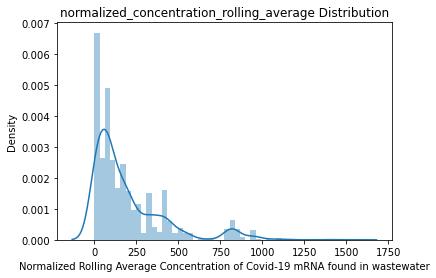

In [61]:
#This is NOT a normal distribution. Uh-oh...
sns.distplot(df.normalized_concentration_rolling_average)
plt.xlabel('Normalized Rolling Average Concentration of Covid-19 mRNA found in wastewater')
plt.title('normalized_concentration_rolling_average Distribution')

C:\Users\Aim\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution Plot of Percent Positivity of Surveilled Counties in MA')

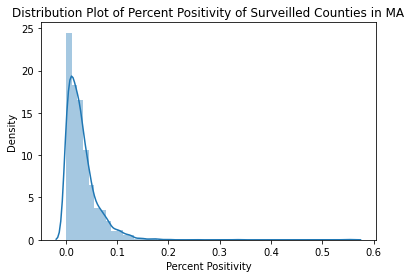

In [62]:
#This is NOT a normal distribution. Uh-oh...
sns.distplot(df['Percent Positivity'])
plt.xlabel('Percent Positivity')
plt.title('Distribution Plot of Percent Positivity of Surveilled Counties in MA')

### Distribution takeaways:
1. Concentration and Positivity are not uniform, shows skewedness
2. Skewedness MAY affect stationarity, but I don't know yet.

Let's explore any correlation gained from this insight.

<AxesSubplot:>

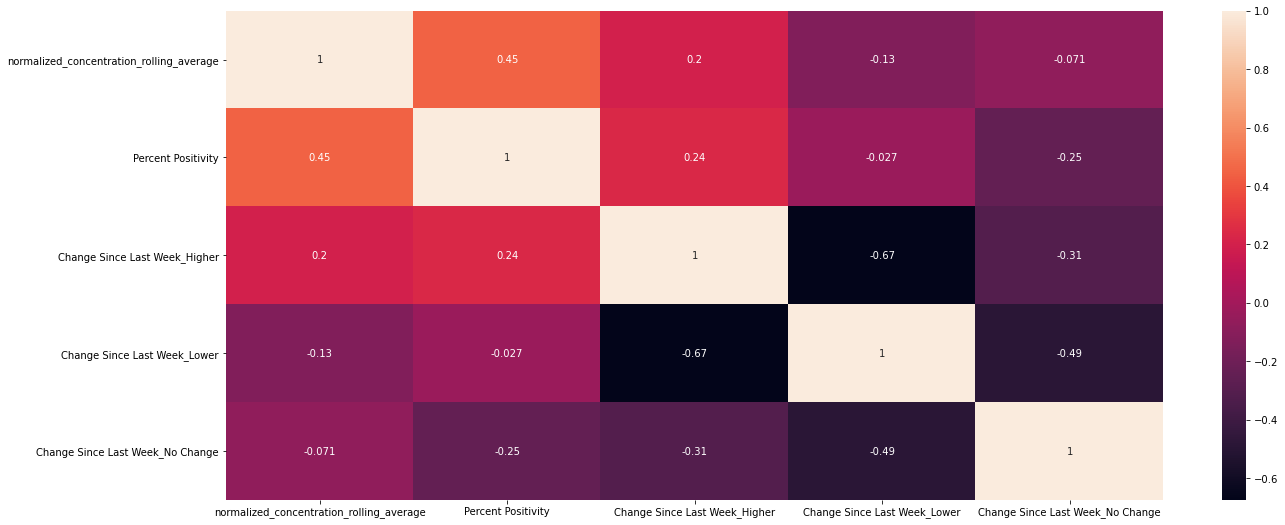

In [63]:
#I need to drop some features or my system won't be able to process the dummy variables for the .corr()

#Why did I think I needed to drop these features?
test = pd.DataFrame(df.drop(columns=['City/Town', 'County', 'population']))
#I know dummies should be reserved to pre-processing but I couldn't help myself
test = pd.get_dummies(test)
plt.figure(figsize = (21,9))
sns.heatmap(test.corr(), annot=True)

Let's focus on the correlation between Percent Positivity and normalized_concentration...

In [64]:
slice = test.columns.difference(['Percent Positivity', 
                                 'normalized_concentration_rolling_average'])
slice2 = test.columns.difference(slice)
test[slice2].corr()

,Percent Positivity,normalized_concentration_rolling_average
Percent Positivity,1.000000,0.446349
normalized_concentration_rolling_average,0.446349,1.000000


There is a MILD correlation between Percent Positivity and normalized_concentration

### Using graphs can be a powerful tool to gain insight into the relationship between features.

Text(0.5, 1.0, 'Percent Positivity vs Surveilled Wastewater in 6 MA Counties')

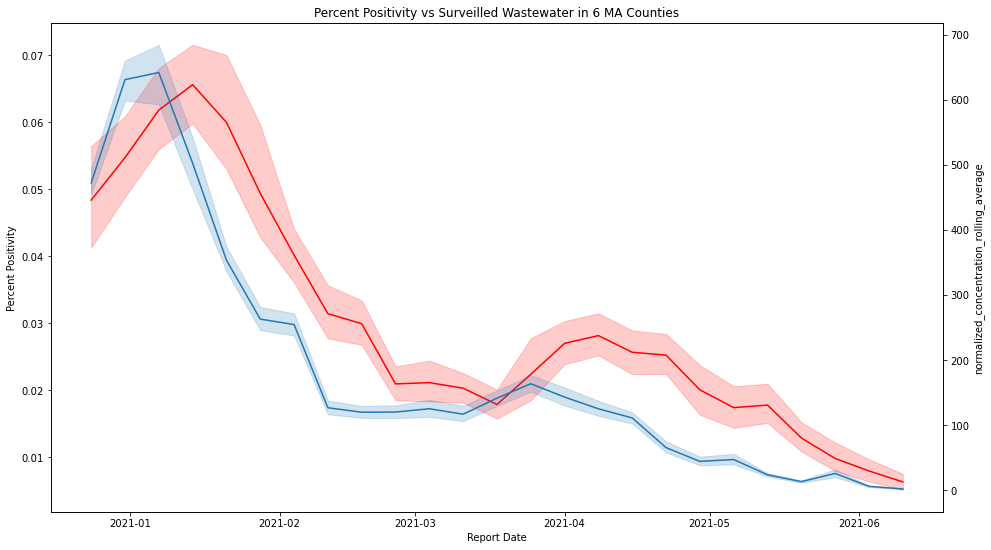

In [65]:
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(y='Percent Positivity', x=df['Report Date'], data=df, color='red')
ax2 = ax.twinx()
sns.lineplot(y='normalized_concentration_rolling_average', x=df['Report Date'], data=df, ax=ax2)
plt.title('Percent Positivity vs Surveilled Wastewater in 6 MA Counties')

### What I've infered from EDA:
The Percent Positivity (which is the actual rate of covid-19 infection) seems to follow the wastewater trend after a set period of time.

Is this more true when focusing on County Level data?

### What do I mean by county-level data?
To use the stock market as a metaphor, when using time-series analysis I don't think you would analyze the entirety of the stock exchange, but look at individual stocks and their closing price, so why not look at individual county data?

Text(0.5, 1.0, 'Percent Positivity vs Surveilled Wastewater (County level data)')

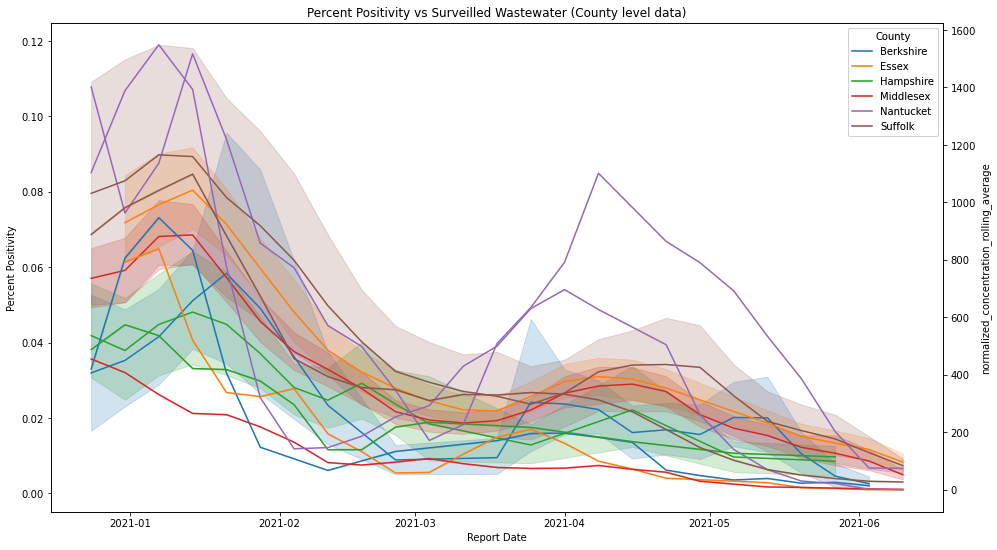

In [66]:
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(y='Percent Positivity', x=df['Report Date'], 
             data=df, hue='County', 
             ax=ax)
ax2 = ax.twinx()
sns.lineplot(y='normalized_concentration_rolling_average', x=df['Report Date'],
             hue='County', data=df, 
             ax=ax2)
plt.title('Percent Positivity vs Surveilled Wastewater (County level data)')

That's messy! Let's clean it up.

[]

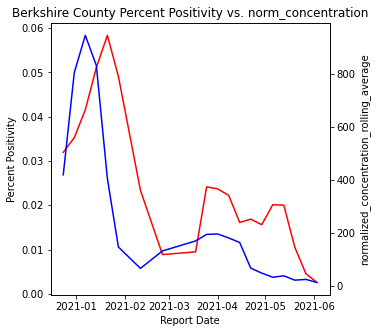

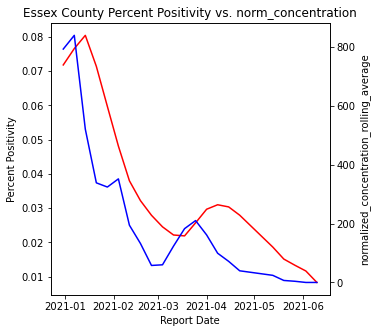

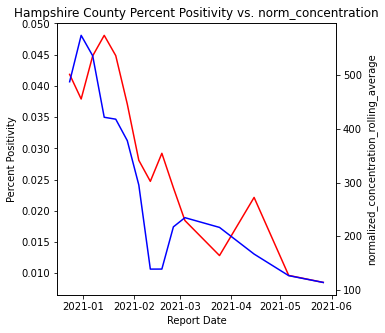

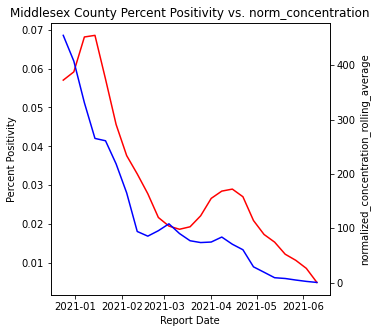

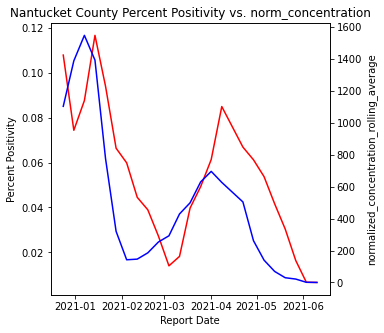

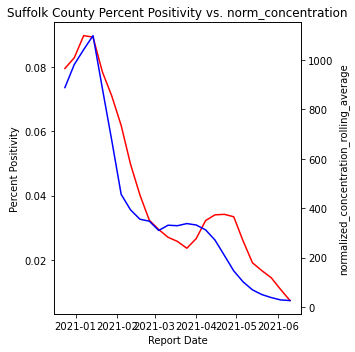

In [67]:
for county in df.County.unique():
    fig, ax = plt.subplots(figsize=(5,5))
    data=df.loc[df.County==county, :]
    sns.lineplot(data=data, x=data['Report Date'], 
                 y=data['Percent Positivity'], ax=ax, 
                 color='red', ci=None)
    ax2 = ax.twinx()
    sns.lineplot(data=data, x=data['Report Date'], 
                 y=data['normalized_concentration_rolling_average'], ax=ax2, 
                 color='blue', ci=None)
    plt.title(county + ' County Percent Positivity vs. norm_concentration')
plt.tight_layout()
plt.plot()

Visually it seems to hold true that the trends of Percent Posi|tivity follows after the normalized_concentration. Let's see if the correlation coefficient is increased if I focused on county-level data.

In [68]:
for county in df.County.unique():
    #fig, ax = plt.subplots(figsize=(6,6))
    data=df.loc[df.County==county, :]
    slice1=data.columns.difference(['Percent Positivity', 
                                    'normalized_concentration_rolling_average'])
    slice2 = data.columns.difference(slice1)
    corr = data[slice2].corr()
    #print(corr.columns)
    #print(type(corr))
    print(f'{county}: \n{corr.normalized_concentration_rolling_average}','\n')

Berkshire: 
Percent Positivity                          0.240292
normalized_concentration_rolling_average    1.000000
Name: normalized_concentration_rolling_average, dtype: float64 

Essex: 
Percent Positivity                          0.675854
normalized_concentration_rolling_average    1.000000
Name: normalized_concentration_rolling_average, dtype: float64 

Hampshire: 
Percent Positivity                          0.392312
normalized_concentration_rolling_average    1.000000
Name: normalized_concentration_rolling_average, dtype: float64 

Middlesex: 
Percent Positivity                          0.642016
normalized_concentration_rolling_average    1.000000
Name: normalized_concentration_rolling_average, dtype: float64 

Nantucket: 
Percent Positivity                          0.777101
normalized_concentration_rolling_average    1.000000
Name: normalized_concentration_rolling_average, dtype: float64 

Suffolk: 
Percent Positivity                          0.779547
normalized_concentration_r

### Insights gained
Correlation changes! As we focus in on the county-level data, we can see some stronger correlation for some counties, and some weaker ones for others. Why? Is it due to the size of the county-level dataset?

In [69]:
for county in df.County.unique():
    data = data=df.loc[df.County==county, :]
    print(f"{county} County's shape: {data.shape}")

Berkshire County's shape: (640, 9)
Essex County's shape: (748, 9)
Hampshire County's shape: (300, 9)
Middlesex County's shape: (1350, 9)
Nantucket County's shape: (24, 9)
Suffolk County's shape: (100, 9)


#### Not entirely convinced the size of the dataset affects the correlation, but am pursuing a time-series forecast of the trend (Percent Positivity) using the normalized_concentration as the predictor.

# EDA (end)

In [70]:
#Saving current df for next Capstone 2 Unit
#df.to_pickle('Unit16FeatureEngineering.pkl') #Commenting out for Github commit

# Pre-processing (Unit 16.3)

## Stationarity: It's a BIG DEAL
1. Stationarity must be determined if we are to use normalized_concentration as a predictor

Why?
Because stationarity determines if the predictor feature is independent or not. If it is independent, we can use it to forecast. 

## Addressing Stationarity:
I know it is a timeseries dataset. I have to test for stationarity with these tests:
1. Does it show a trend?
2. Does it show cyclicality or seasonality?
3. Does the variance change with time?
4. Does the dynamics change with time?

In [71]:
#load pickle for this unit
with open('Unit16FeatureEngineering.pkl', 'rb') as f:
    df_preprocessing = pickle.load(f)
    
df_preprocessing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   datetime64[ns]
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   category      
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   category      
 5   City/Town                                 3162 non-null   category      
 6   Percent Positivity                        3162 non-null   float64       
 7   Change Since Last Week                    3162 non-null   category      
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: category(4), datetime64[ns](

In [72]:
df_preprocessing.set_index('Report Date', inplace=True)

## The gold standard for stationarity: White Noise
White Noise means that each occurrence of the white noise is NOT dependent on the previous one. It is stationary. Let's see what white noise looks like, and understand how we can use the Augmented Dickey Fuller Test to quantify its stationarity. 

(-33.265036879348195, 0.0, 0, 999, {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}, 2822.9684880432073)


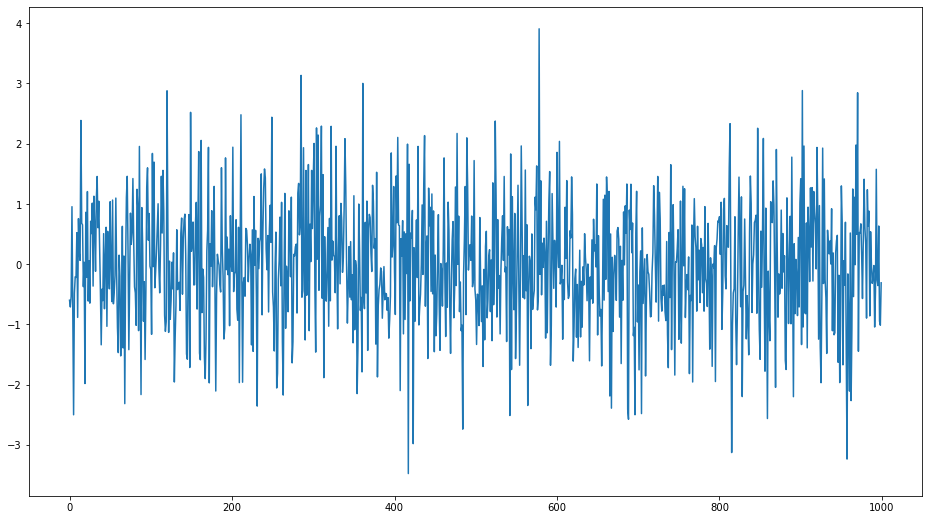

In [73]:
fig, ax = plt.subplots(figsize=(16,9))

#creating white noise using a gaussian distribution between 0 and 1 with 1000 samples
white_noise = [random.gauss(0,1) for i in range(1000)]

#casting white_noise into a Series so it may be graphed
white_noise = pd.Series(white_noise)
sns.lineplot(data=white_noise)

print(sm.tsa.stattools.adfuller(white_noise))

### Analyzing ADF (white noise)
1. first number is -20.1395 (test statistic). The more negative, the more likely the set is stationary
2. second number 0.000 (test p-value). If p is small, reject H0 == reject non-stationarity
3. The dictionary contains critical test statistics.

#### AD Fuller shows 'white noise' is a stationary timeseries.

## The gold standard for NON-Stationary time-series: Random Walk

Random walk is different than white-noise. Each of its successive steps is dependent on the previous step. Think 'drunkard's walk'

### Let's see random walk, and its ADF scores.

In [74]:
#creating a random_walk to graph and then to compare ADF. 
#Needed some help here, found the code here:
# https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/
#import random as random # moved to beginning of notebook
random.seed(1)

random_walk = []

random_walk.append(-1 if random.random() < 0.5 else 1)
for i in range(1000):
    movement = -1 if random.random() < 0.5 else 1
    #here's the key point, the current value is a modification of the previous value [i-1]
    value = random_walk[i-1] + movement
    random_walk.append(value)
    

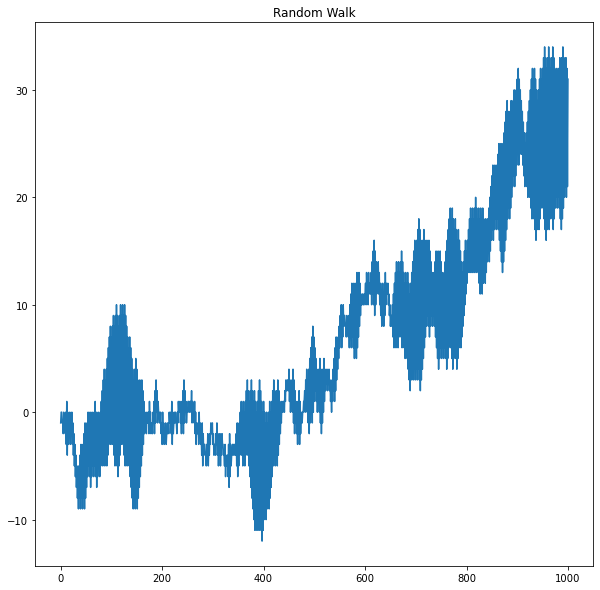

(0.2916040853708628, 0.9769559908579484, 1, 999, {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}, 2774.8549226193245)


In [75]:
fig, ax = plt.subplots(figsize = (10,10))
sns.lineplot(data=random_walk)
plt.title('Random Walk')
plt.show()
random_walk_ADF = sm.tsa.stattools.adfuller(random_walk)
print(random_walk_ADF)

### Analyzing ADF (Random Walk)
1. First number is 0.29160 (test statistic). It is positive!
2. Second number 0.97700 (rounded) (test p-value). The p-value is significantly greater than 0.05. We CANNOT reject the H0 non-stationarity. Random walk is NOT stationary. 
3. The dictionary contains critical test statistics.

#### AD Fuller shows 'Random Walk' is a stationary timeseries.

## Testing for county-level stationarity

In [76]:
#encountered some LinAlgErrors when running Dickey-Fuller, reloaded df from pickle as df_0
with open('Unit16FeatureEngineering.pkl', 'rb') as f:
    df_0 = pickle.load(f)

df_0.set_index('Report Date', inplace=True)

<AxesSubplot:xlabel='Report Date', ylabel='normalized_concentration_rolling_average'>

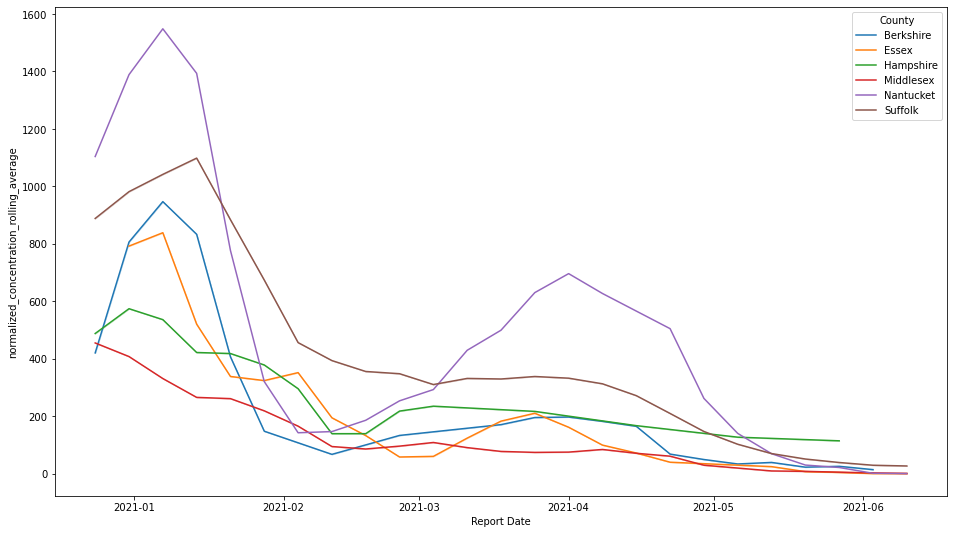

In [77]:
plt.figure(figsize=(16,9))
data = pd.DataFrame(df_0.drop_duplicates())
#print(len(data), len(df_0))
sns.lineplot(data=data, x=data.index,y=data['normalized_concentration_rolling_average'], hue='County')

### IF I just look at the aggregate (all six counties) ADF...

In [78]:
print(sm.tsa.stattools.adfuller(df_0['normalized_concentration_rolling_average']))

(-3.470362199089018, 0.008781690115955018, 28, 3133, {'1%': -3.4324389453866817, '5%': -2.8624629669644266, '10%': -2.5672613171352516}, 31441.743031096827)


### Analyzing ADF (aggregated normalized concentration rolling average)
1. first number is -3.45 (test statistic). The more negative, the more likely the set is stationary
2. second number 0.009 (test p-value). If p is small, reject H0 == reject non-stationary
3. The dictionary contains critical test statistics.

AD Fuller the aggregate of 'normalized_concentration_rolling_average' is a stationary timeseries.

### A deeper look into stationarity
While the ADF may show stationarity, I need to remind myself that this is an aggregate of the six county-level data set. 
Because the goal is to forecast wastewater concentrations of Covid-19 by county, I need to check for stationarity at the county level!

In [79]:
test_county_ADF_method = county_ADF(df_0, 'normalized_concentration_rolling_average')

for county in test_county_ADF_method.keys():
    print(county, test_county_ADF_method[county])

Berkshire {'test-statistic': -8.14872810372554, 'p-value': 9.826948680796276e-13}
Essex {'test-statistic': -1.5389302303555474, 'p-value': 0.5141728049273325}
Hampshire {'test-statistic': -1.1417617418031638, 'p-value': 0.6981338694357283}
Middlesex {'test-statistic': -1.7064520585626328, 'p-value': 0.4277912857757429}
Nantucket {'test-statistic': 0.005477996686873882, 'p-value': 0.9589827747521857}
Suffolk {'test-statistic': -3.030362872805752, 'p-value': 0.032154544360425225}


## The Point:
This process of determining stationarity is germane to determining whether there is structure in the data.
If structure exists then we can learn something from that time series.

Some counties have stronger negative test-statistics (Berkshire) and very significant p-values (Berkshire, again).

Others aren't as negative nor are their p-values showing statistical significance towards rejecting non-stationarity.

By showing that normalized_concentration at the county level is non-stationary it necessitates pre-processing before any 
insightful modelling can be done. 

## I have to Pre-Process the county-level data for stationarity!

Otherwise, the time-series dataset of 'normalized_concentration' cannot statistically be used as a independent variable to forecast the trend!

### First Two attempts at Pre-Processing:
Power Transformations transform the skewedness of the dataset's distribution. As I've seen a very left-skewed distribution, could using power transformations make my dataset at the county level more stationary? 


### Hypothesis Testing
I will test this hypothesis with two transformations:
1. Yeo-Johnon
2. Box-Cox

H0-YJ: Yeo-Johnson Transformation does not make the county-level data more stationary.
HA-YJ: Yeo-Johnson does make the county-level data more stationary.

H0-BC: Box-Cox Transformation does not make the county-level data more stationary
H0-BC: Box-Cox does make the county-level data more stationary.

p-value is set at p=0.05.

In [80]:
#creating a county:df mapped dictionary for convenience
county_dict = {}
for county in df_0.County.unique(): 
    county_dict[county] = pd.DataFrame(df_0.loc[df_0.County==county, 
                                       ['County', 'normalized_concentration_rolling_average',
                                        'Percent Positivity']]
                                      )
    county_dict[county].drop_duplicates(inplace=True)
test = county_dict['Berkshire']
county_ADF(test, 'normalized_concentration_rolling_average')

{'Berkshire': {'test-statistic': -8.14872810372554,
  'p-value': 9.826948680796276e-13}}

In [81]:
import scipy.stats as stats
#this is the unprocessed control
control_stationarity = county_ADF(df_0, 'normalized_concentration_rolling_average')

### Testing for Yeo-Johnson

In [82]:
#conducting a yeo-johnson transformation, and testing to see if it changes at the county level
yeo_test = df_0.copy()
yeo_test = yeo_test.loc[:, ['County', 'normalized_concentration_rolling_average']].drop_duplicates()
transform_to_yeo = yeo_test.normalized_concentration_rolling_average.values

data=stats.yeojohnson(transform_to_yeo) #returns in a list of [array, maxlog]
yeo_test['yeo'] = data[0]
yeo_test.drop(columns='normalized_concentration_rolling_average', inplace=True)
yeo_test_stationarity = county_ADF(yeo_test, 'yeo')

for county in df_0.County.unique():
    print(county+' Control: ', control_stationarity[county], 
      '\n'+county+' Yeo-Johnson Test: ', yeo_test_stationarity[county],'\n')

Berkshire Control:  {'test-statistic': -8.14872810372554, 'p-value': 9.826948680796276e-13} 
Berkshire Yeo-Johnson Test:  {'test-statistic': 2.2803686628948885, 'p-value': 0.9989423731414838} 

Essex Control:  {'test-statistic': -1.5389302303555474, 'p-value': 0.5141728049273325} 
Essex Yeo-Johnson Test:  {'test-statistic': 2.062551894591108, 'p-value': 0.9987489178471907} 

Hampshire Control:  {'test-statistic': -1.1417617418031638, 'p-value': 0.6981338694357283} 
Hampshire Yeo-Johnson Test:  {'test-statistic': -1.4992445105074585, 'p-value': 0.5338850356001192} 

Middlesex Control:  {'test-statistic': -1.7064520585626328, 'p-value': 0.4277912857757429} 
Middlesex Yeo-Johnson Test:  {'test-statistic': 0.15940463490148302, 'p-value': 0.9698905745425836} 

Nantucket Control:  {'test-statistic': 0.005477996686873882, 'p-value': 0.9589827747521857} 
Nantucket Yeo-Johnson Test:  {'test-statistic': 2.8713916164521933, 'p-value': 1.0} 

Suffolk Control:  {'test-statistic': -3.030362872805752

### Yeo-Johnson Transformation made it worse!
P-values were significantly above 0.05.
Not enough evidence to reject the H0. Yeo-Johnson did not make the county level data more stationary.

#### Try for Box-Cox Power Transformation

In [83]:
#conducting a box-cox transformation, and testing to see if it changes at the county level
boxcox_test = df_0.copy()
box_negative_filter = (boxcox_test['normalized_concentration_rolling_average'] ==0)
boxcox_test = boxcox_test.loc[~box_negative_filter, ['County', 'normalized_concentration_rolling_average']].drop_duplicates()
transform_to_box = boxcox_test.normalized_concentration_rolling_average.values

data=stats.boxcox(transform_to_box) #returns in a list of [array, maxlog]
boxcox_test['boxcox'] = data[0]
boxcox_test.drop(columns='normalized_concentration_rolling_average', inplace=True)
boxcox_test_stationarity = county_ADF(boxcox_test, 'boxcox')

for county in df_0.County.unique():
    print(county+' Control: ', control_stationarity[county], 
      '\n'+county+' Box-Cox Test: ', boxcox_test_stationarity[county],'\n')

Berkshire Control:  {'test-statistic': -8.14872810372554, 'p-value': 9.826948680796276e-13} 
Berkshire Box-Cox Test:  {'test-statistic': 2.407089492460328, 'p-value': 0.9990136070097886} 

Essex Control:  {'test-statistic': -1.5389302303555474, 'p-value': 0.5141728049273325} 
Essex Box-Cox Test:  {'test-statistic': 212.11147250766982, 'p-value': 1.0} 

Hampshire Control:  {'test-statistic': -1.1417617418031638, 'p-value': 0.6981338694357283} 
Hampshire Box-Cox Test:  {'test-statistic': -1.4871275081840876, 'p-value': 0.5398692943223813} 

Middlesex Control:  {'test-statistic': -1.7064520585626328, 'p-value': 0.4277912857757429} 
Middlesex Box-Cox Test:  {'test-statistic': 1.6033452044333374, 'p-value': 0.9978675770838004} 

Nantucket Control:  {'test-statistic': 0.005477996686873882, 'p-value': 0.9589827747521857} 
Nantucket Box-Cox Test:  {'test-statistic': 1.9115039584898343, 'p-value': 0.9985463041184205} 

Suffolk Control:  {'test-statistic': -3.030362872805752, 'p-value': 0.032154

### Same with Box-Cox
P-values were significantly above 0.05.
Not enough evidence to reject the H0. Box-Cox did not make the county level data more stationary.


### Let's see if taking the difference of the current observation with the n-ith observation yields insight.

I will be using .diff() and plotting the auto-correlation function to determine any difference.

#### Note: The following code was inspired from
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

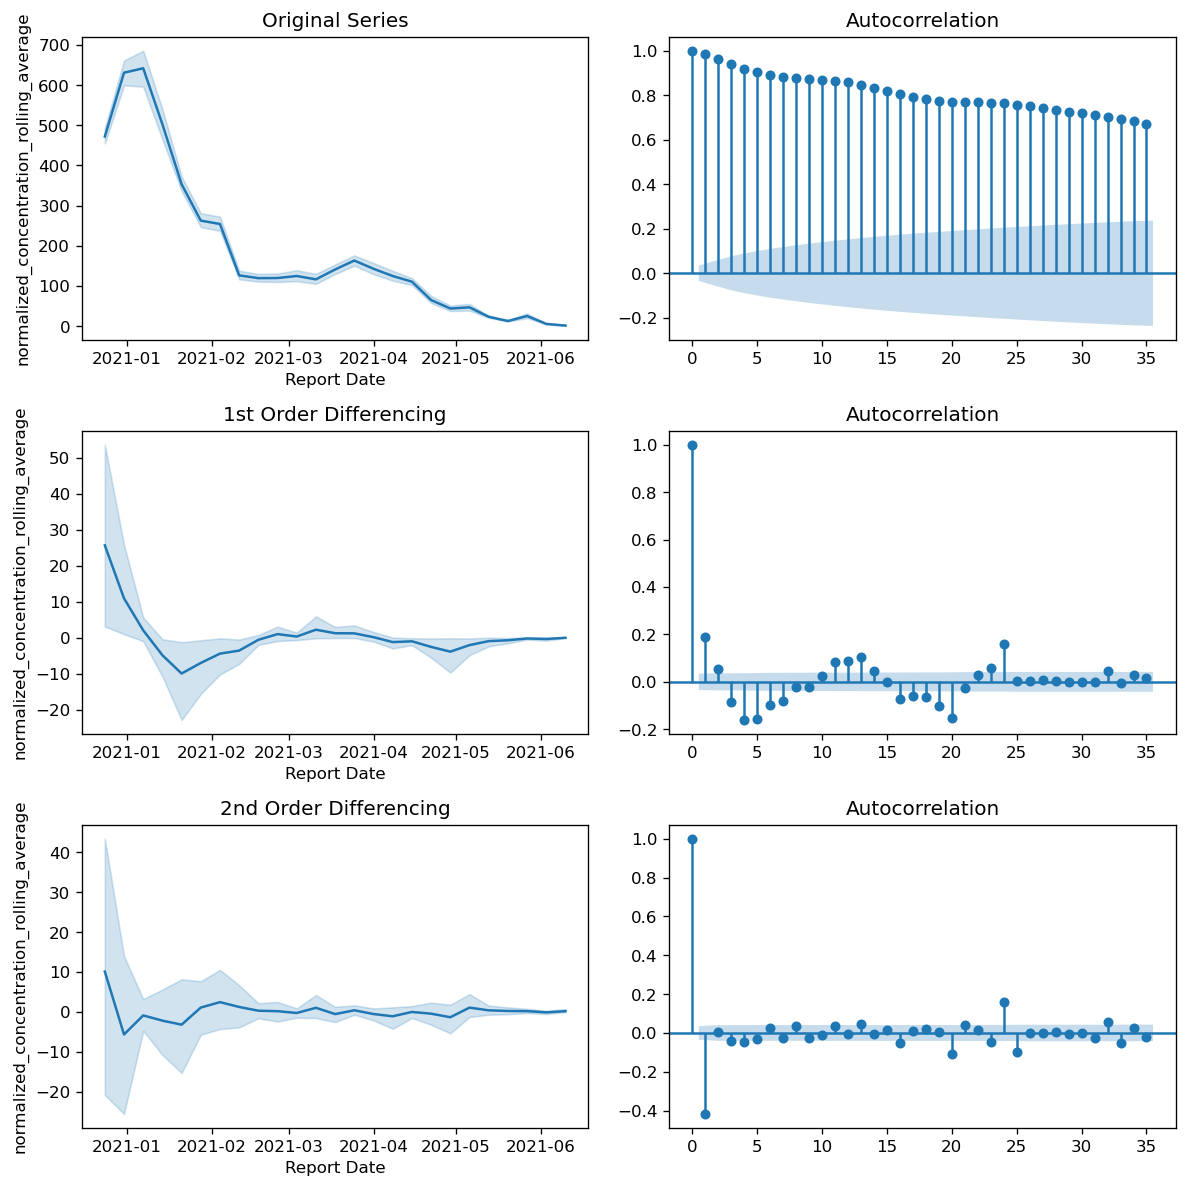

In [84]:
plt.rcParams.update({'figure.figsize':(10,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
sns.lineplot(data=df_0, x= df_0.index, 
             y = df_0['normalized_concentration_rolling_average'], 
             ax=axes[0,0])
axes[0, 0].set_title('Original Series')
plot_acf(df_0['normalized_concentration_rolling_average'], ax=axes[0, 1])

# 1st Differencing
sns.lineplot(data=df_0, x=df_0.index, 
             y=df_0['normalized_concentration_rolling_average'].diff(), 
             ax=axes[1,0])
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_0['normalized_concentration_rolling_average'].diff().dropna(), 
         ax=axes[1, 1])

# 2nd Differencing
sns.lineplot(data=df_0, x=df_0.index, 
             y=df_0['normalized_concentration_rolling_average'].diff().diff(), 
             ax=axes[2,0])
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_0['normalized_concentration_rolling_average'].diff().diff().dropna(), 
         ax=axes[2, 1])

plt.tight_layout()
plt.show()

In [85]:
# testing the ADF values for 1st and 2nd Order Differencing. 
first_order_diff = pd.Series(df_0['normalized_concentration_rolling_average'].diff().dropna())
second_order_diff = pd.Series(df_0['normalized_concentration_rolling_average'].diff().diff().dropna())

first_order_ADF = sm.tsa.stattools.adfuller(first_order_diff)
second_order_ADF = sm.tsa.stattools.adfuller(second_order_diff)

In [86]:
#Here's the control ADF (aggregate of all 6 counties)
print(sm.tsa.stattools.adfuller(df_0['normalized_concentration_rolling_average']))

(-3.470362199089018, 0.008781690115955018, 28, 3133, {'1%': -3.4324389453866817, '5%': -2.8624629669644266, '10%': -2.5672613171352516}, 31441.743031096827)


In [87]:
print(first_order_ADF[:2])

(-12.35112126353084, 5.822388419030004e-23)


In [88]:
print(second_order_ADF[:2])

(-20.513698433742277, 0.0)


## Stronger Stationarity
The ACF plots show stronger stationarity in both 1st and 2nd order differencing. 

This is confirmed when testing with ADF, where both features more negative test statistics and smaller p-values than the normalized_concentration series. 


Here's where I have to choose.

The aggregated normalized_concentration has been tested and confirmed to have weak stationarity. When diving deeper at the county-level, some of the dataset shows non-stationarity.. For the time-series, differencing makes it stationary. What I have to be careful is with overfitting the differencing. I am unsure if that is what is happening with the 2nd Order Differencing, as the p-value is 0 and ACF plots at lag-1 is negative. I fear as I saw such a p-value during my ADF test of white_noise, this may be the case.

## Reviewing AR and MA models and defining the ARIMA model
A pure AR model is one where the forecasted value depends only on its lags.

A pure MA model is where the forecasted value depends only on the lagged forecast errors.

The error terms are the errors of the AR models of the respective lags.

The ARIMA model is where the time series was differenced at least once to make it stationary, and combines the AR and MA terms.

In words:

"Predicted Value = Constant + Linear combination Lags of Y (up to p lags) + Linear Combination of Lagged forecast errors (up to q lags)"

## Something to keep in mind:
I know I reference p,d,q terms for the ARIMA model, but an easier way to remember is:
p = AR
d = I
q = MA

Instead of thinking 'p,d,q' terms, think 'AR, I, MA' terms!

## Lesson Learned:
I went down the rabbit hole once to do a grid-search of ARIMA for the aggregate normalized_concentration dataset, but once again, I remind all readers you must look at the COUNTY-LEVEL to use differencing to affect stationarity. 

Let's plot the acf for the county level data.

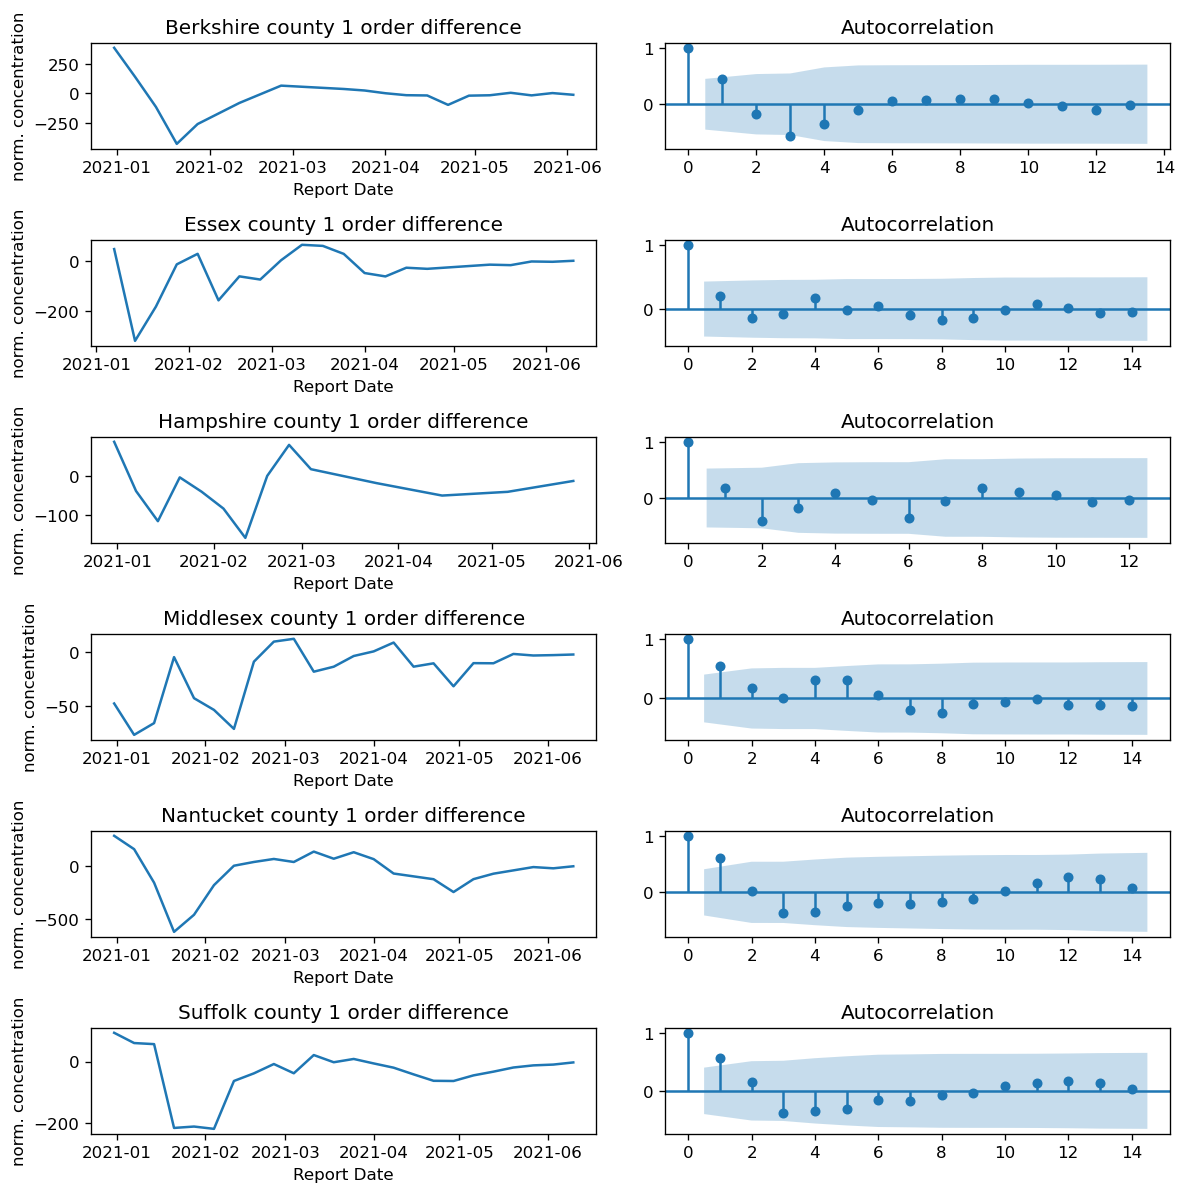

In [89]:
#First order differencing of the county-level's normalized_concentration time series
counties_ACF(df_0, 1)

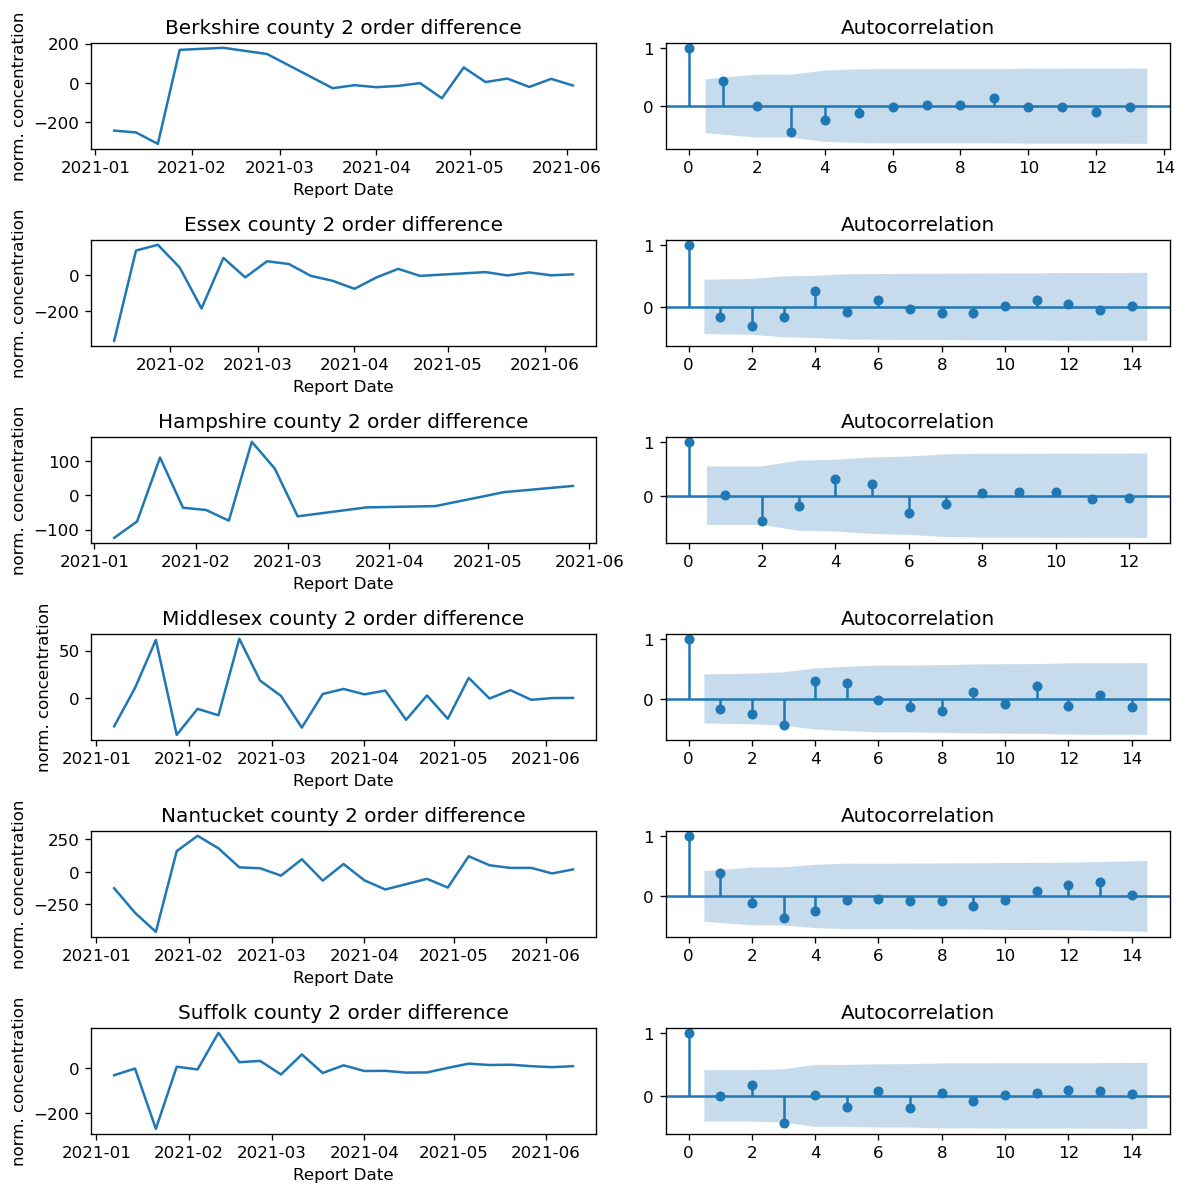

In [90]:
#second order differencing of the county-level's normalized_concentration time series
counties_ACF(df_0, 2)

## My limitations:
Here's where my depth of knowledge limits me. I had a difficult time judging which was the best order of differncing. The second order differencing's ACF plots show that some of the first lagged values went negative. Is that bad? I'm not sure.

Here is my attempt to test which is better.

## County-level ADF and ARIMA
I'll be focusing on Middlesex county for these reasons:
1. One of my original dataset is Cambridge's wastewater surveillance conducted by Biobot. 
2. While Cambridge data isn't normalized_concentration_rolling_average, there may be reason to use it later.
3. Cambridge is part of Middlesex county.

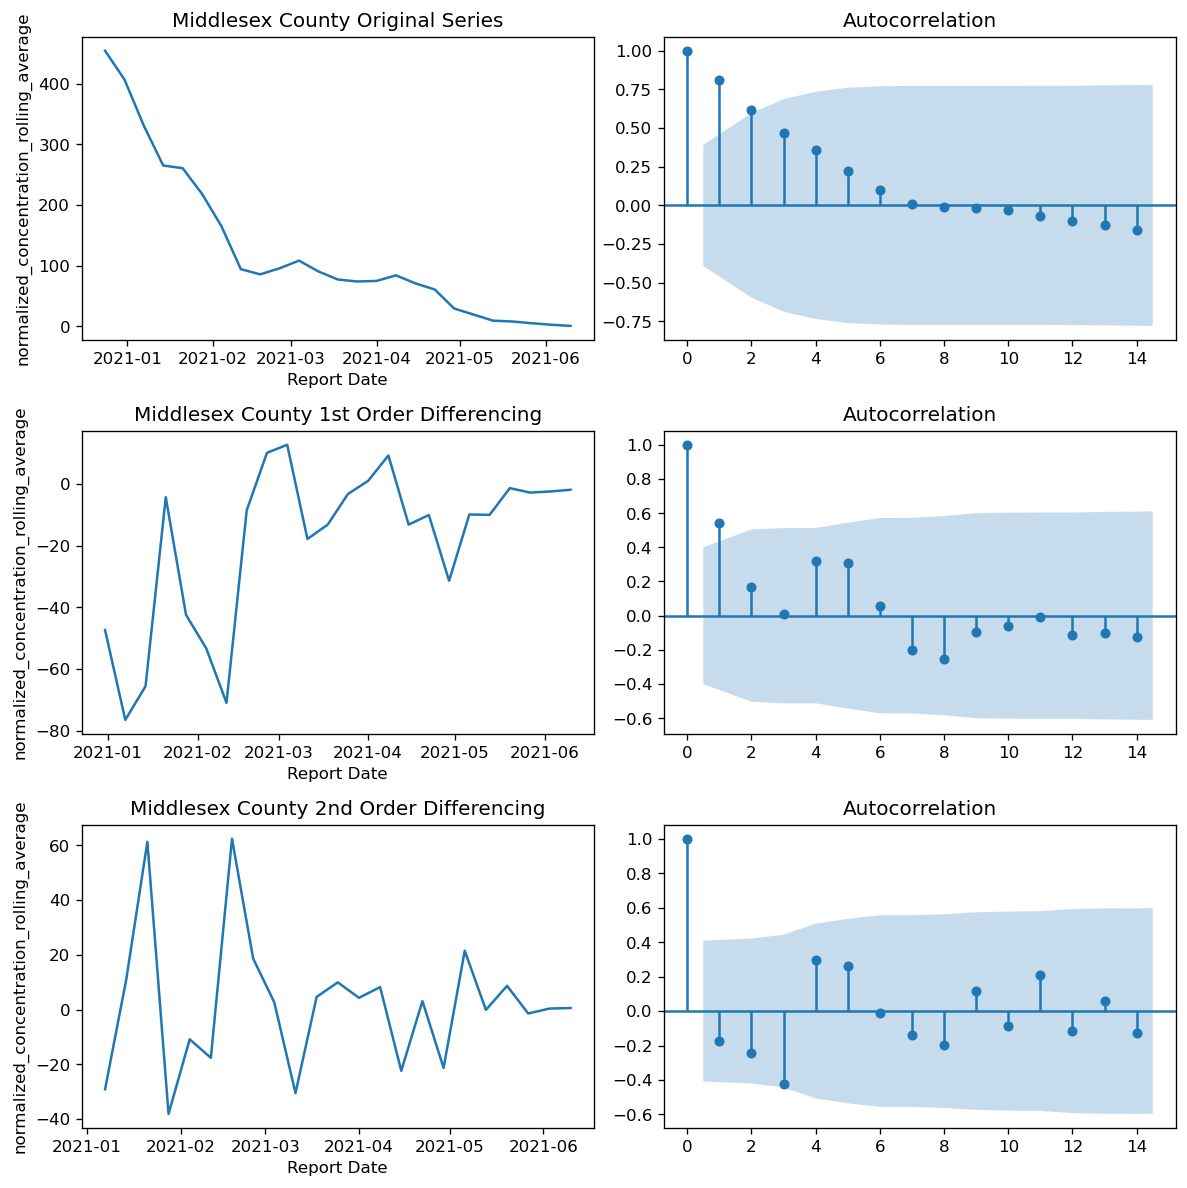

In [91]:
#A constant reminder that there are duplicates within the county data (from the cities within that County) 
# must drop_duplicates()!
Middlesex = pd.DataFrame(df_0.loc[df_0['County']=='Middlesex', 
                                  'normalized_concentration_rolling_average'].drop_duplicates())

county_ACF(df_0, 'Middlesex', None)

In [92]:
Middlesex_ADF = sm.tsa.stattools.adfuller(Middlesex['normalized_concentration_rolling_average'])
Middlesex_first_order = sm.tsa.stattools.adfuller(Middlesex['normalized_concentration_rolling_average']
                                                  .diff()
                                                  .dropna())
Middlesex_second_order = sm.tsa.stattools.adfuller(Middlesex['normalized_concentration_rolling_average']
                                                  .diff()
                                                  .diff()
                                                  .dropna())
Middlesex_third_order = sm.tsa.stattools.adfuller(Middlesex['normalized_concentration_rolling_average']
                                                  .diff()
                                                  .diff()
                                                  .diff()
                                                  .dropna())
#Printing the test stat and p-values
print('Original: ', Middlesex_ADF[:2], '\n', 
      'First Order Differencing: ', Middlesex_first_order[:2], '\n', 
      'Second Order Differencing: ', Middlesex_second_order[:2], '\n', 
      'Third Order Differencing: ', Middlesex_third_order[:2])

Original:  (-1.7064520585626328, 0.4277912857757429) 
 First Order Differencing:  (-4.706567082276423, 8.179458108509737e-05) 
 Second Order Differencing:  (-2.2419173459994304, 0.19138499102185375) 
 Third Order Differencing:  (-1.0193491750783565, 0.7461418811413996)


### Insights gained:
1. First order differencing worked best for Middlesex county
2. Had the most negative test-statistic, and the smallest p-value
3. For Middlesex county data, a d=1 is best for the p,d,q parameter.
4. For the p in p,d,q, I will move onto using a partial autocorrelation function

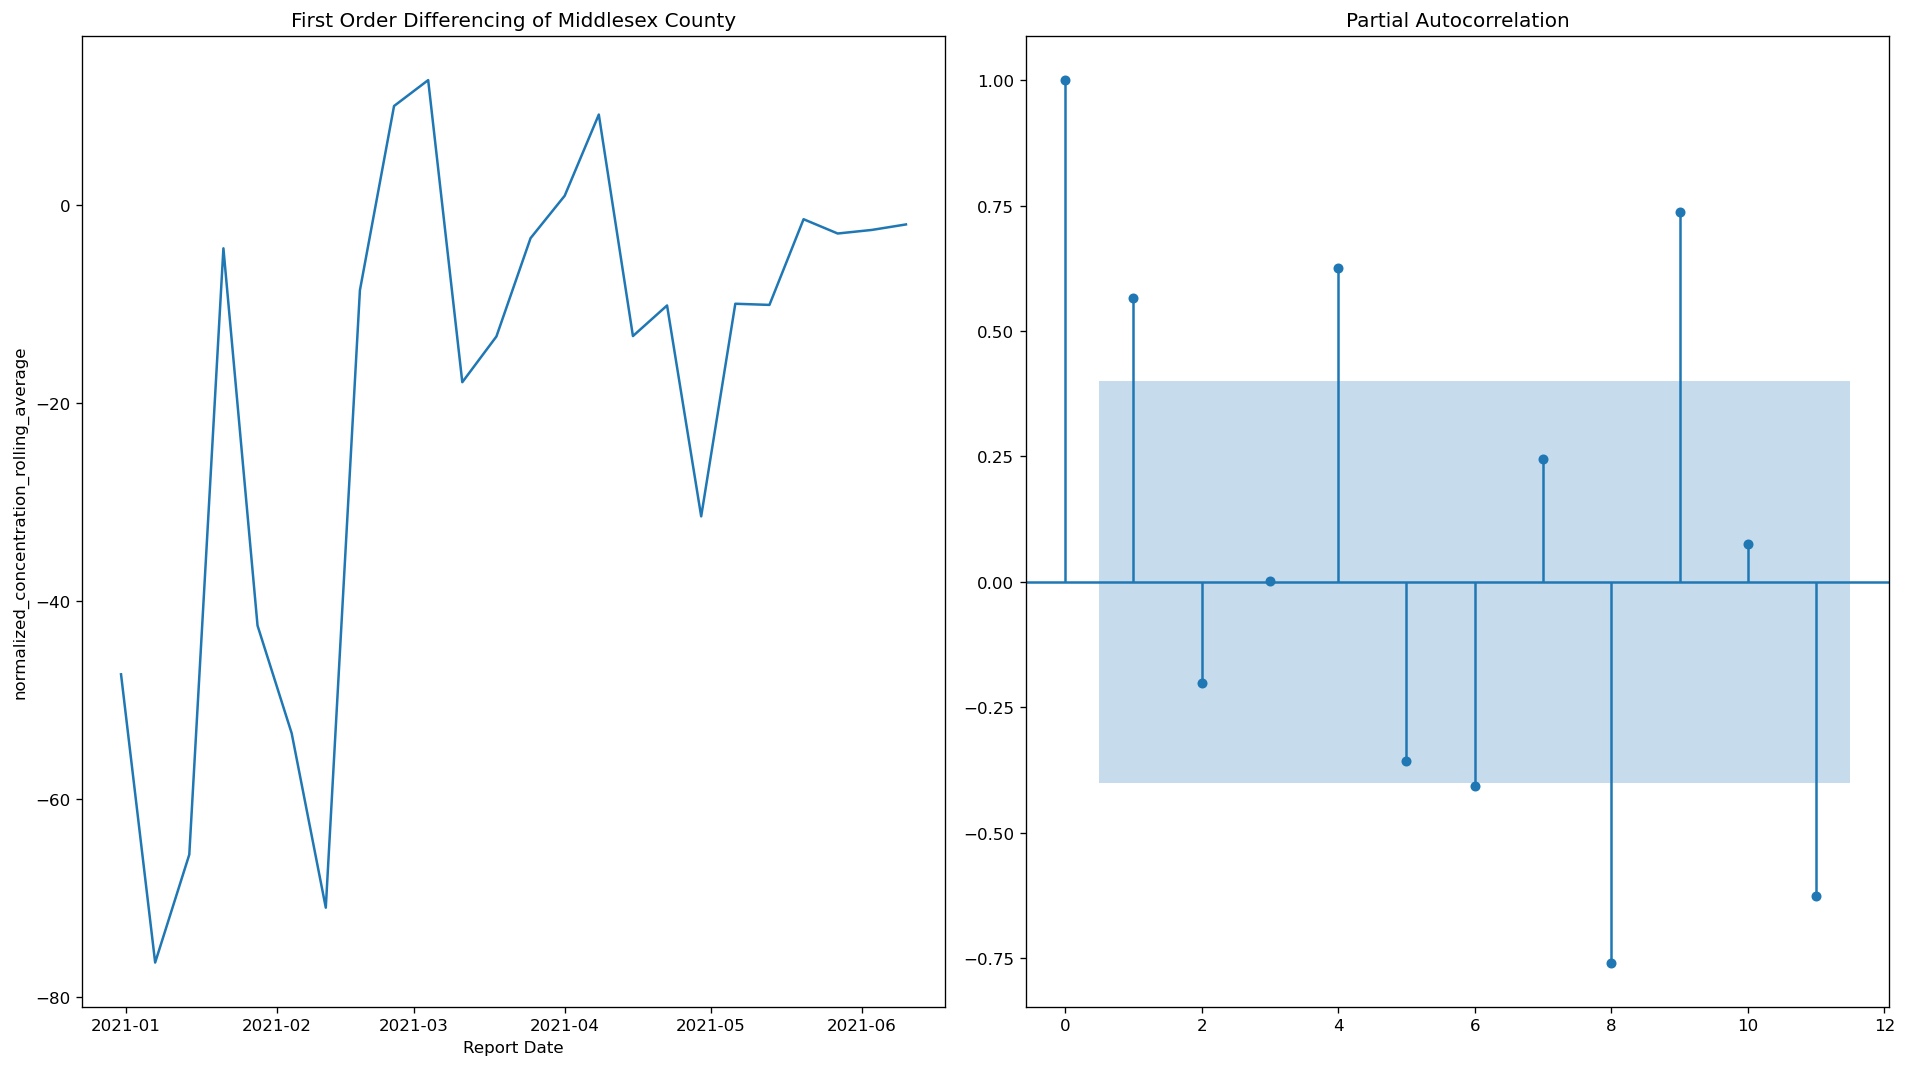

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(16,9))
pacf_test = Middlesex['normalized_concentration_rolling_average']
#mean = pacf_test.diff().describe()[1]
ax[0].set_title('First Order Differencing of Middlesex County')
sns.lineplot(data= pacf_test, x= pacf_test.index, y = pacf_test.diff(), ax=ax[0])
#ax[0].axhline(mean, color='red', label='mean')

#note to myself, because the county dataset is small (12-14nobs), I have to set lags < 50% of nobs.
plot_pacf(pacf_test.diff().dropna(), lags=((pacf_test.shape[0]//2)-1), ax=ax[1])
plt.tight_layout()
plt.show()

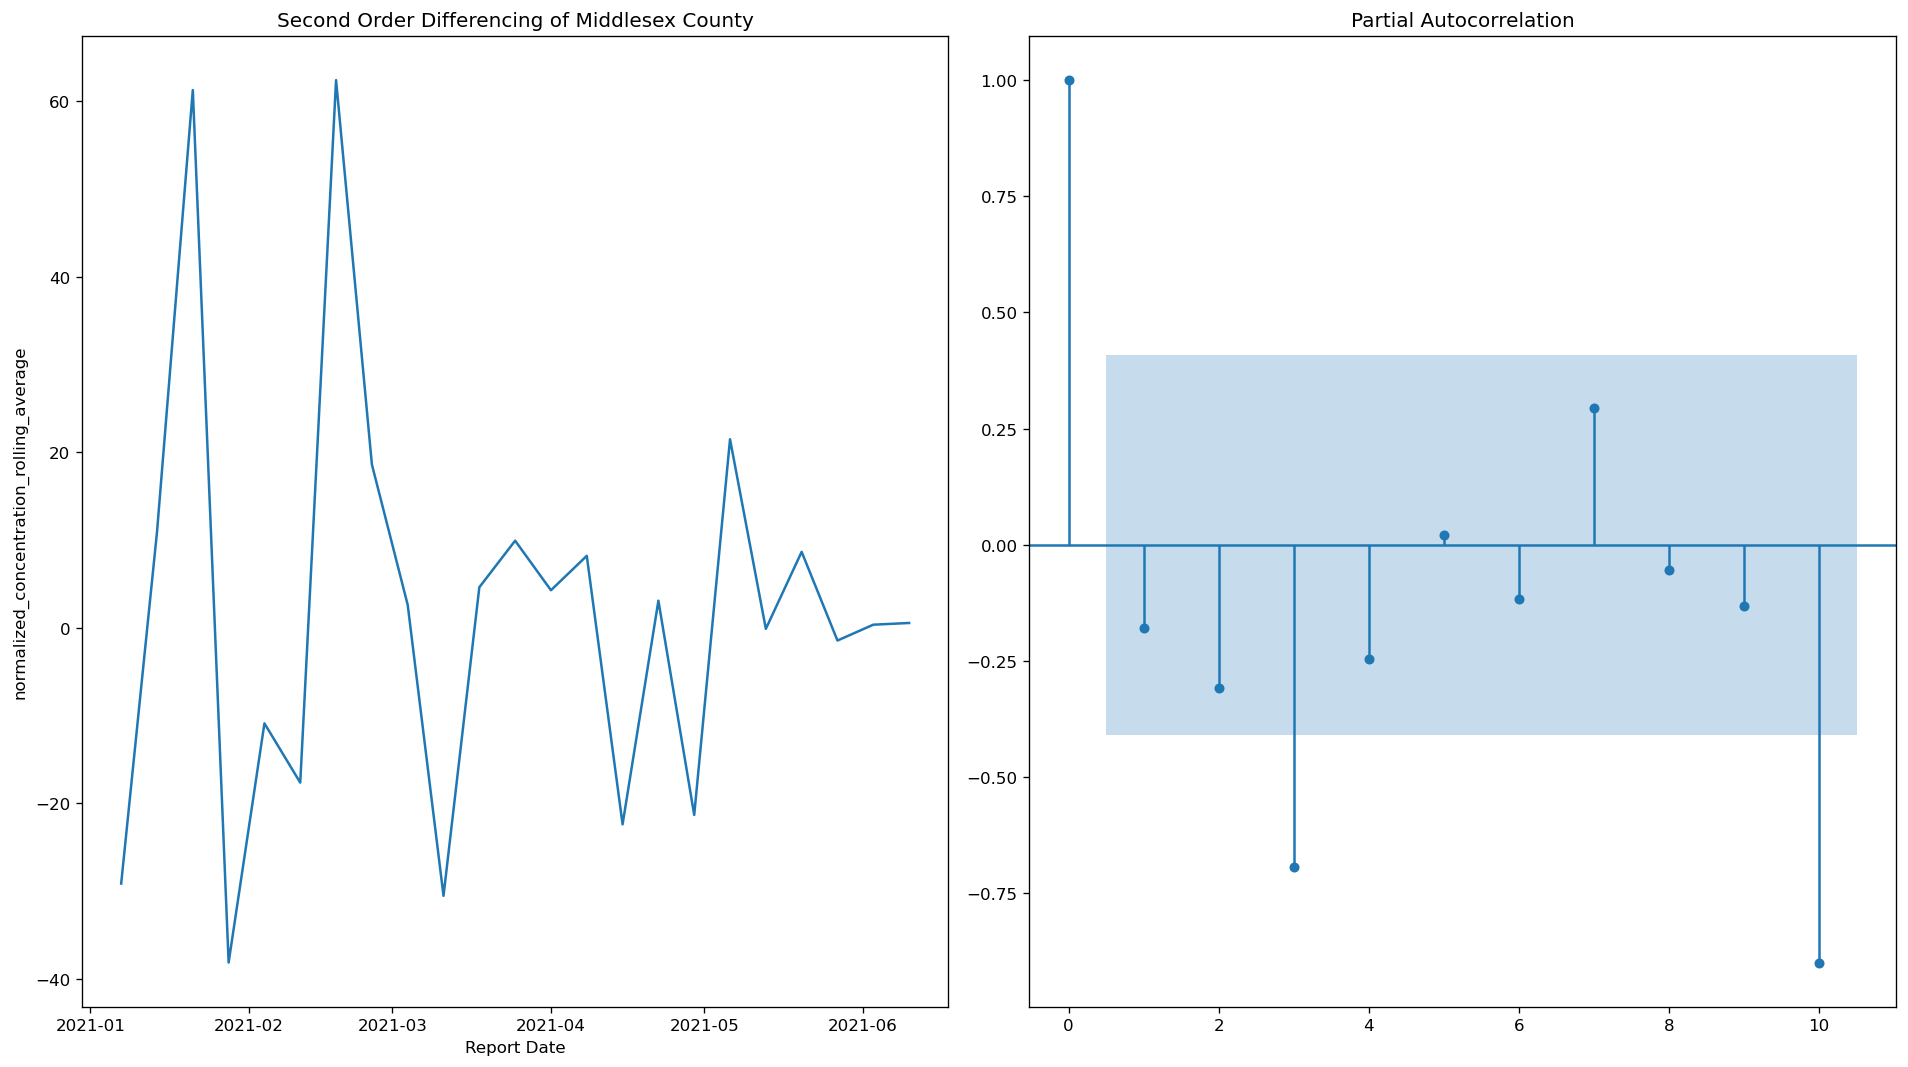

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(16,9))
pacf_test = Middlesex['normalized_concentration_rolling_average']
#mean = pacf_test.diff().describe()[1]
ax[0].set_title('Second Order Differencing of Middlesex County')
sns.lineplot(data= pacf_test, x= pacf_test.index, y = pacf_test.diff().diff(), ax=ax[0])
#ax[0].axhline(mean, color='red', label='mean')

#note to myself, because the county dataset is small (12-14nobs), I have to set lags < 50% of nobs.
plot_pacf(pacf_test.diff().diff().dropna(), lags=((pacf_test.shape[0]//2)-2), ax=ax[1])
plt.tight_layout()
plt.show()

C:\Users\Aim\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


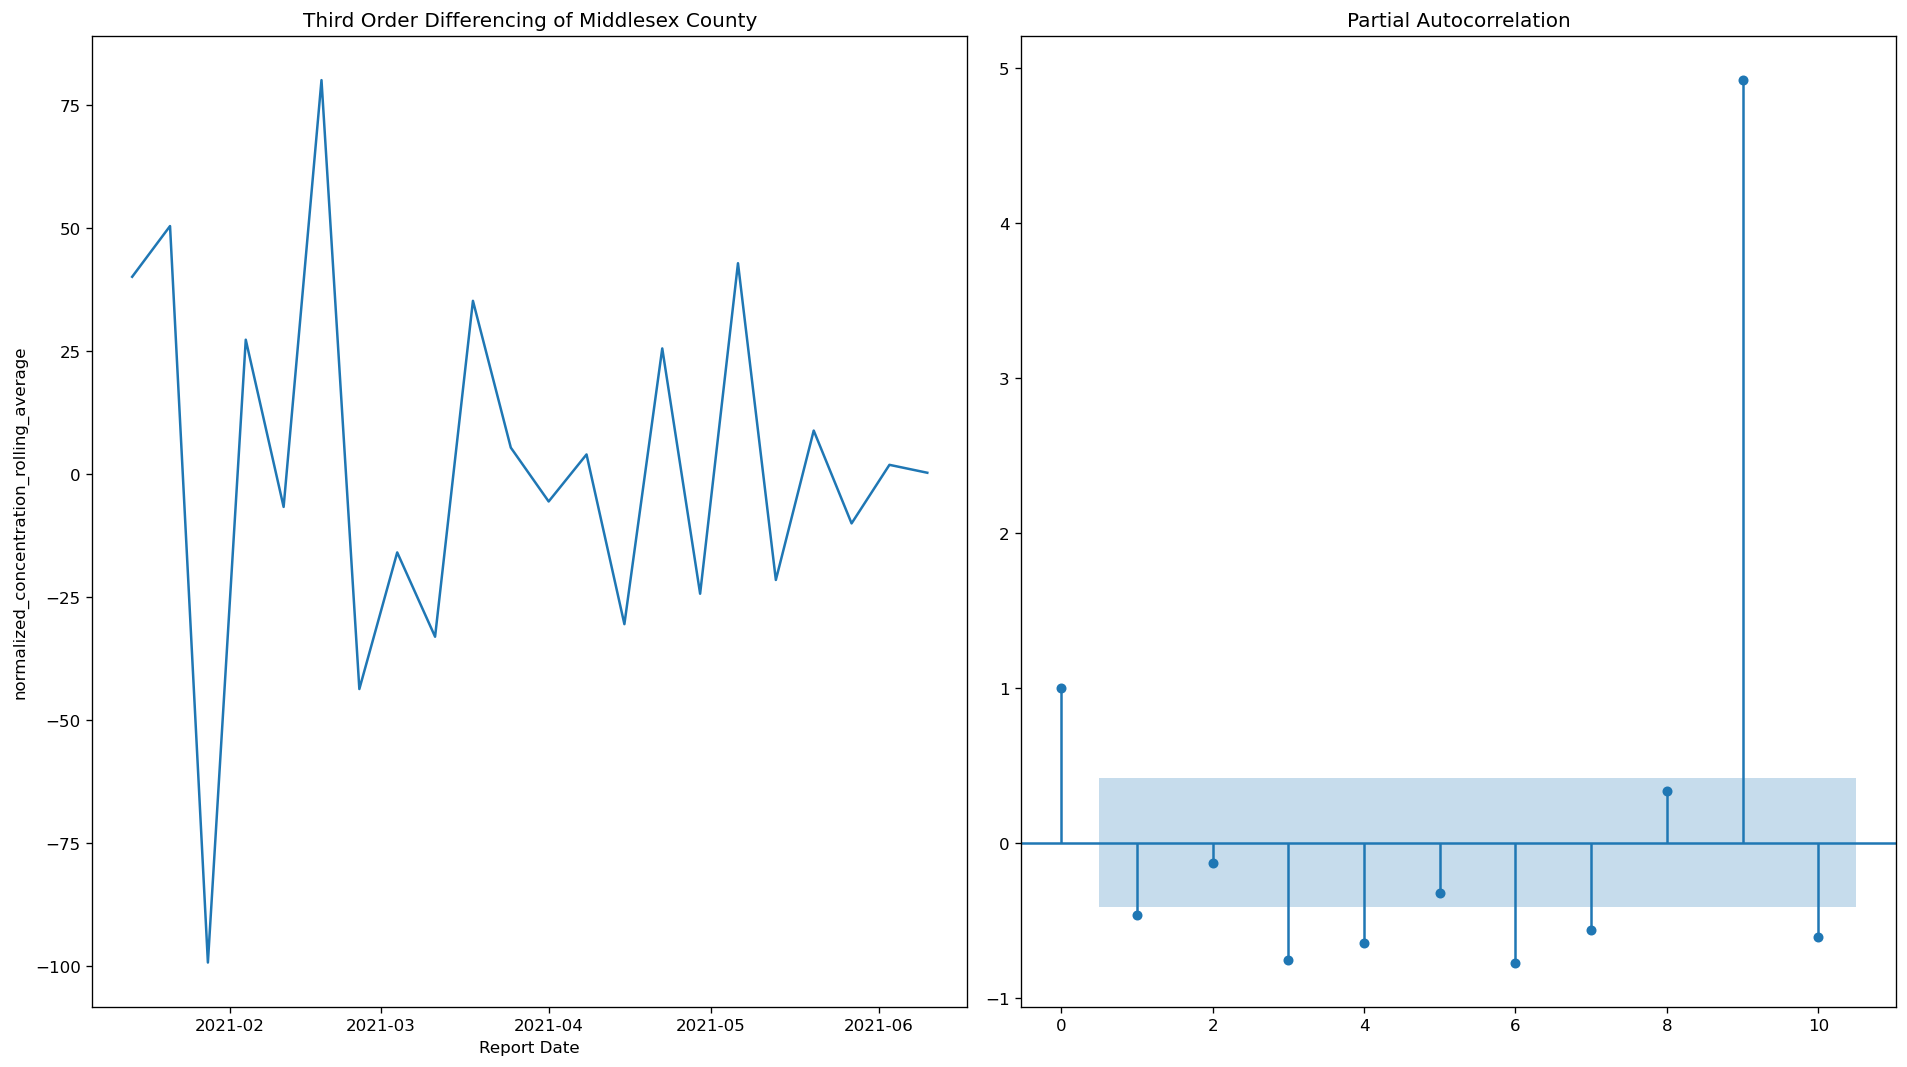

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(16,9))
ax[0].set_title('Third Order Differencing of Middlesex County')
sns.lineplot(data= pacf_test, x= pacf_test.index, 
             y = pacf_test.diff().diff().diff(), 
             ax=ax[0])
#ax[0].axhline(mean, color='red', label='mean')

#note to myself, because the county dataset is small (12-14nobs), I have to set lags < 50% of nobs.
plot_pacf(pacf_test.diff().diff().diff().dropna(), 
          lags=((pacf_test.shape[0]//2)-2), 
          ax=ax[1])
plt.tight_layout()
plt.show()

Possibly p=1.

I already ran plot_ACF for Middlesex above, and for the chosen d=1 (1st order differencing) the lag-1 value was above
the significance area. 

So, for Middlesex ARIMA let's start off with a 1, 1, 1 ARIMA model

### Middlesex ARIMA:

In [96]:
# Silencing the ARIMA deprecation warning

warnings.filterwarnings('ignore') 

# 1,1,1 ARIMA Model
Middlesex_model = ARIMA(Middlesex.values, order=(1,1,1))
Middlesex_model_fit = Middlesex_model.fit()
print(Middlesex_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   24
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -112.019
Method:                       css-mle   S.D. of innovations             25.752
Date:                Fri, 10 Sep 2021   AIC                            232.038
Time:                        01:29:02   BIC                            236.750
Sample:                             1   HQIC                           233.288
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.9279      5.256     -3.601      0.000     -29.230      -8.625
ar.L1.D.y      1.0000      0.047     21.415      0.000       0.908       1.092
ma.L1.D.y     -1.0000      0.001  -1785.189      0.0

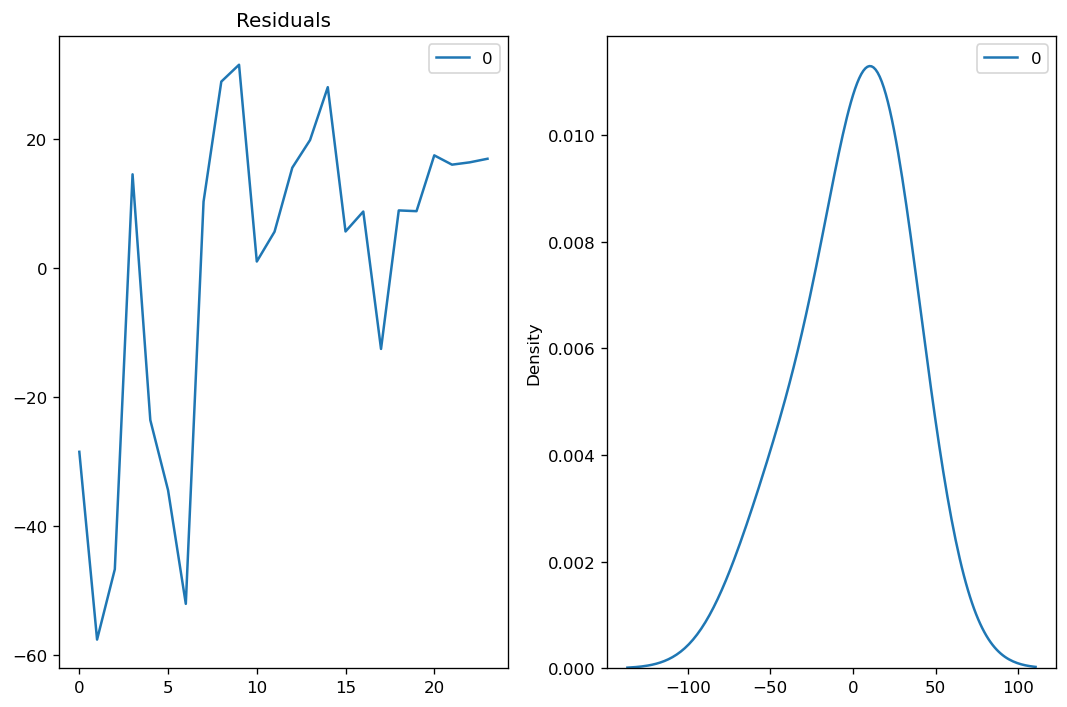

In [97]:
#Plotting 1,1,1 ARIMA residuals and looking at the Kernel Density
Middlesex_residuals = pd.DataFrame(Middlesex_model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(9,6))
Middlesex_residuals.plot(title='Residuals', ax=ax[0])
sns.kdeplot(data=Middlesex_residuals, bw=1, ax=ax[1])
plt.tight_layout()
plt.show()

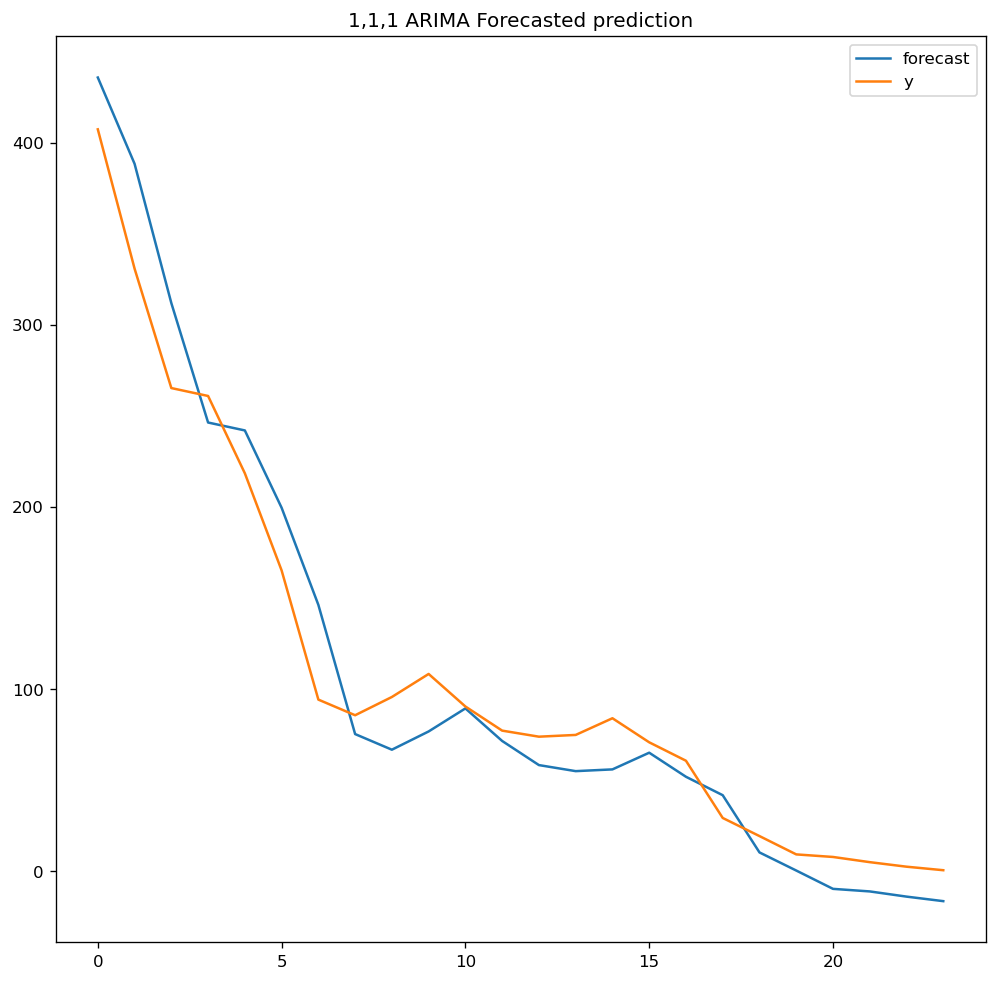

In [98]:
#Actual vs. Forecasted using 1,1,1 ARIMA
Middlesex_model_fit.plot_predict(dynamic=False)
plt.title('1,1,1 ARIMA Forecasted prediction')
plt.show()

## Modelling verdict (so far):
1. Not great. AIC is high
2. This model may not work on the other counties!

## Out-of-Time Cross Validation
1. Requires partitioning the time series
2. Takes steps back and then forecast into the future with as many steps taken backwards
3. Compare forecast against the actuals

## Train-Test splitting time-series dataset:

In [99]:
#create a Training and Testing Set
#There are 25 nobs for Middlesex, I'll split it 20:5
#Lesson learned - by manually setting the partition, this may impede future ML attempts!
Middlesex.shape

#If I had time, I think this is where I would've implemented the windowing function
#Where I partitioned a subset of the timeseries to train, and then subset+1 to test
#I'd then perform some kind of gradient boosting on that model and continue onto the next subsetted window
train = Middlesex[:20]
test = Middlesex[20:]

# Modelling:
Using ARIMA 1,1,1 Model for Middlesex data

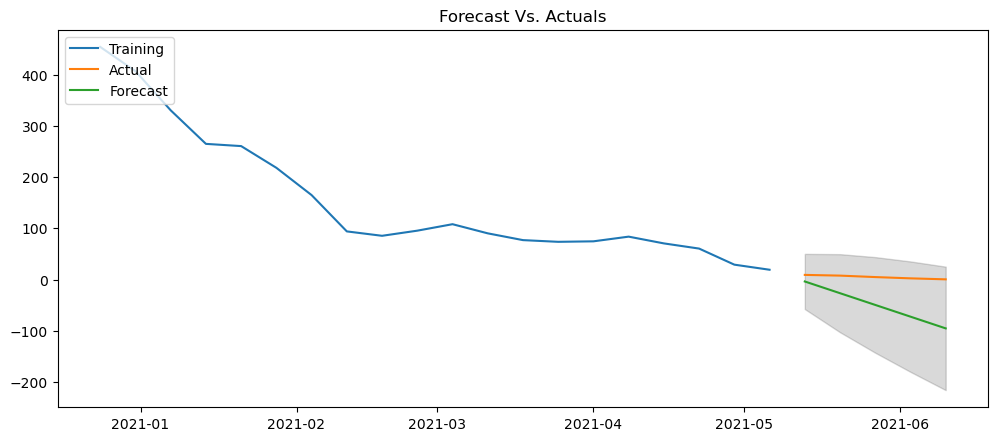

In [100]:


#Buildling ARIMA Model
model = ARIMA(train, order=(1,1,1))
fitted = model.fit(disp=-1)

#forecast with 95% confidence
fc, se, conf = fitted.forecast(5, alpha=0.05)

#make a panda series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

#plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)

plt.title('Forecast Vs. Actuals')
plt.legend(loc='upper left')
plt.show()

### Something is rotten in Denmark...
Forecast is going down, whilst actual isn't. The direction is off. 
Also, am I forecasting for a more than a week's worth in the partition? Forecasts are only viable for however many lagged periods you used in your AR term. Must remember this!

I will try implementing stepwise increments to the p,d,q terms using auto_arima()
to see if my forecast can improve.

Auto_arima() is analogous to the supervised learning ML's grid_search concept. Using it and stipulating to choose the scores which yield the best 'Augmented Dickey-Fuller' value ensures that the stationarity of the differenced time-series data is not in question. 

Auto_arima() then yields the best score in accordance to its AIC score. The lower, the better.

In [107]:
#Making a dict where keys() are counties and values() are their auto_arima() models
counties_dict = {} #k:v are county:df
counties_ARIMA = {}
for county in df_0.County.unique():
    counties_dict[county] = pd.DataFrame(df_0.loc[df_0['County']==county,
                                    'normalized_concentration_rolling_average'].drop_duplicates())

#Copy here to model metrics
for county, df in counties_dict.items():
    print(county)
    model = pm.auto_arima(df.values, start_p=1, start_q=1,
                          test='adf', max_p=3, max_q=3, max_d=3,
                          m=1, d=1, seasonal=False,
                          start_P=0, D=0, trace=True, error_action='ignore',
                          suppress_warnings=True, stepwise=True)
    counties_ARIMA[county] = model

Berkshire
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=241.703, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=249.120, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=243.797, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=242.776, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=247.487, Time=0.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=233.135, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=230.446, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=231.065, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=230.447, Time=0.04 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 0.589 seconds
Essex
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=253.418, Ti

### Using auto_arima(), forecast for all six counties

This is the code to demonstrate what the method 'County_modelling' is doing. It performs an auto_arima() grid search on teh specified county, partitions it, and using the p,d,q parameters from auto_arima() it forecasts an out-of-sample trend for the normalized_concentration.

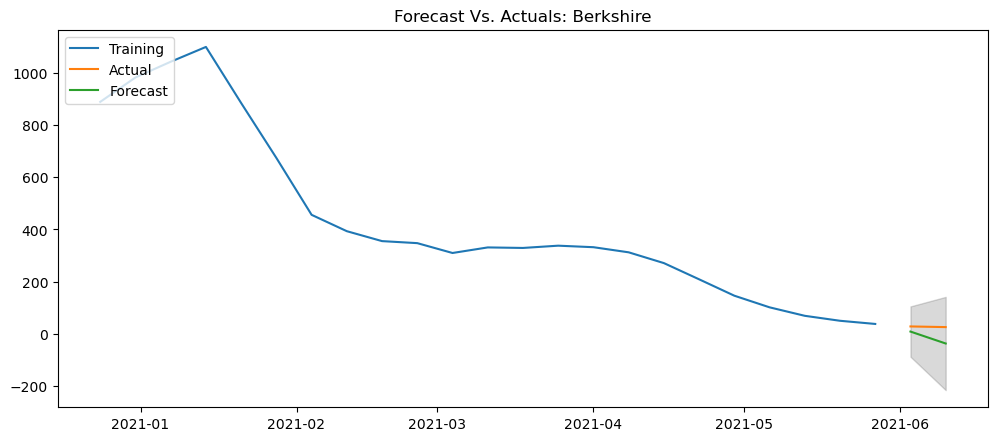

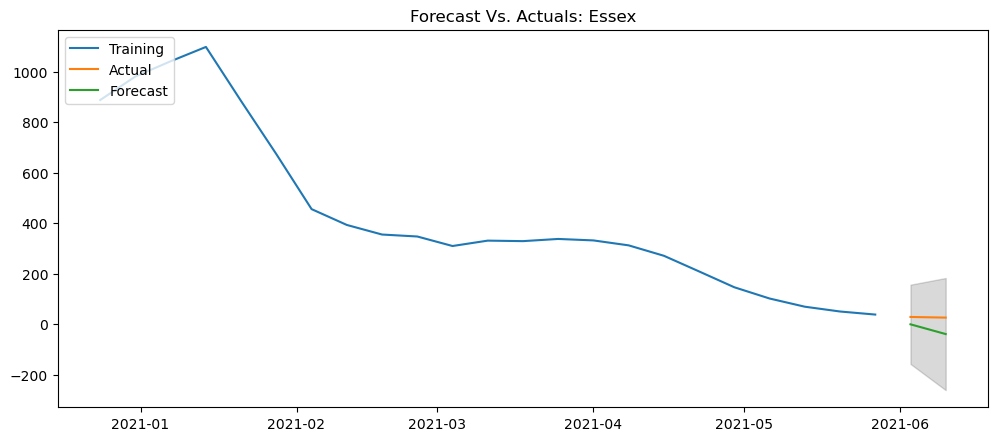

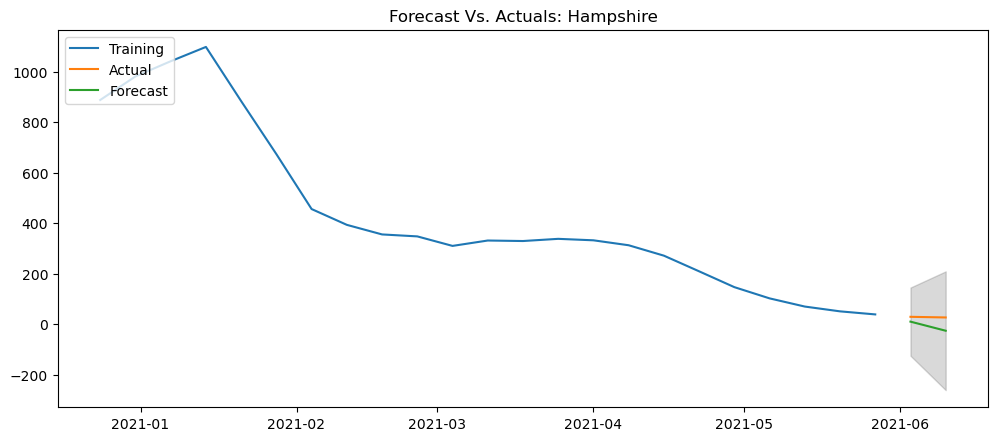

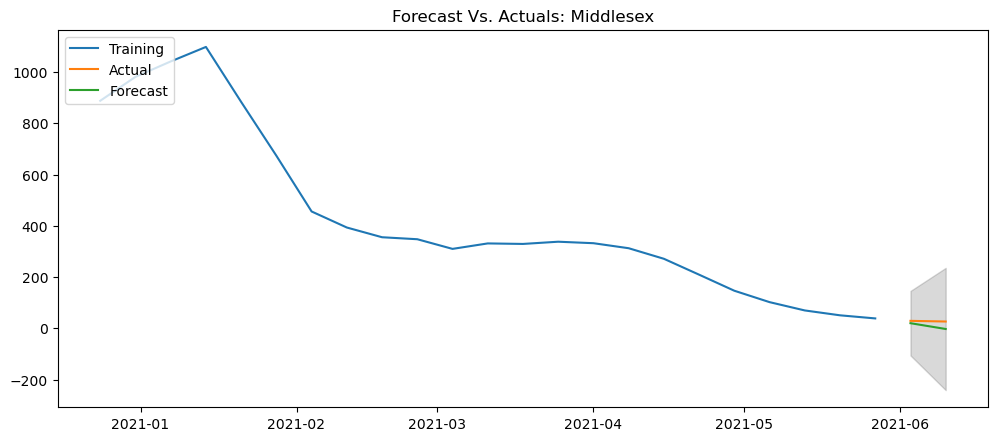

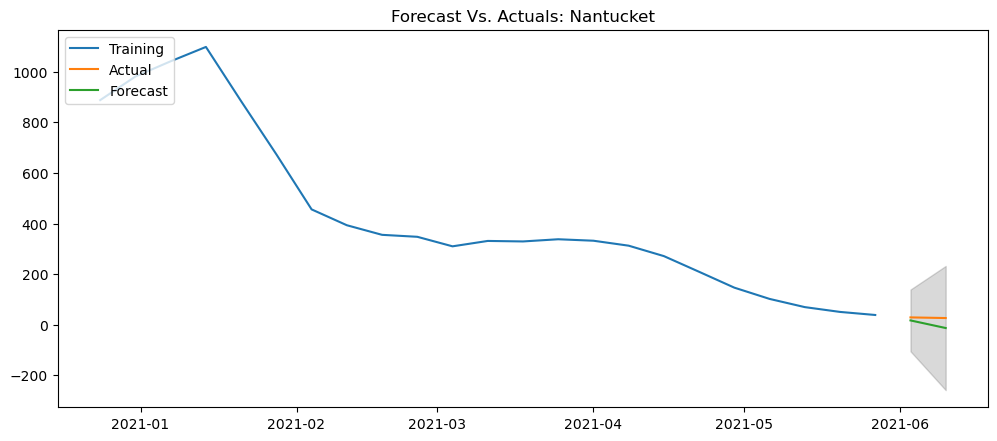

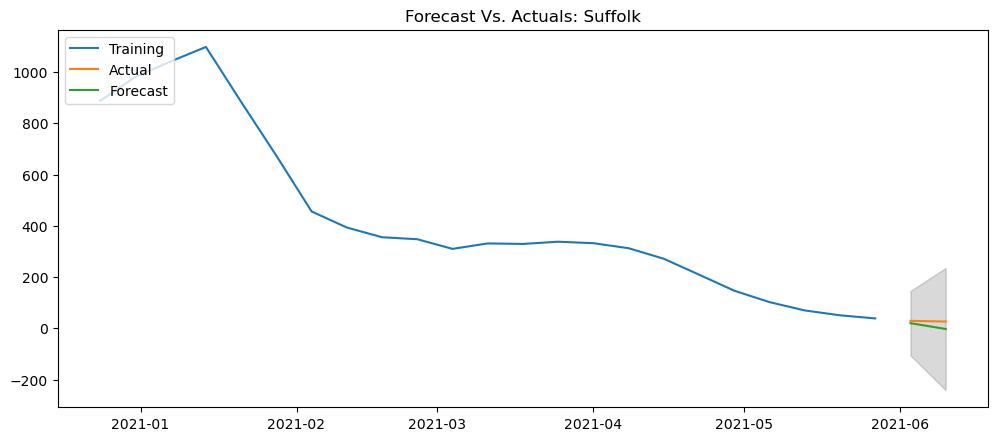

In [102]:
import re #Must move this to the beginning of the notebook

#reminder: I already computed best p,d,q terms from auto_arima()
#it is stored in counties_ARIMA.values() and i'll call it as 'best_model' below

for county, best_model in counties_ARIMA.items():
    for county_, df in counties_dict.items():
        if county == county_:
            #Defining the test train partition using the shape of the dataframe
            #whatever is being multiplied to .shape[0] is the test size percentage
            test_size = round(df.shape[0]*.10)
            df_slice = int(df.shape[0]) - test_size
        
        #This is not a good time-series partition
        #As the partition is a percentage of the series, eventually it will yield a line
        #train = df[:df_slice]
        #test = df[df_slice:]
        train = df[:-2]
        test = df[-2:]

    #convert best_model into a string, and then slice it to extract needed p,d,q values
    text = str(best_model)
    x = text[6:13] #this is the slice of the (p,d,q) in best_model
    p,d,q = int(x[1]), int(x[3]), int(x[5])
    
    #Create the ARIMA model using train and the auto_arima p,d,q values
    model = ARIMA(train, order=(p,d,q))
    fitted = model.fit(disp=-1)

    #forecast with 95% confidence
    fc, se, conf = fitted.forecast(len(test), alpha=0.05)

    #make a panda series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    #Plot all the counties 
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='Training')
    plt.plot(test, label='Actual')
    plt.plot(fc_series, label='Forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)

    plt.title('Forecast Vs. Actuals: ' + str(county))
    plt.legend(loc='upper left')
    #plt.show()

## Methods for ARIMA forecasting by County 

Note, for added sophistication, I reduced the testing size of the partition by using the fifth argument of County_modelling, stating the test_size should equal 0.1.

By using the smallest test size I could, it fits more in line with the p-values found by auto_arima().

In [103]:
for county, df in counties_dict.items():
    print(county, df.columns)

Berkshire Index(['normalized_concentration_rolling_average'], dtype='object')
Essex Index(['normalized_concentration_rolling_average'], dtype='object')
Hampshire Index(['normalized_concentration_rolling_average'], dtype='object')
Middlesex Index(['normalized_concentration_rolling_average'], dtype='object')
Nantucket Index(['normalized_concentration_rolling_average'], dtype='object')
Suffolk Index(['normalized_concentration_rolling_average'], dtype='object')


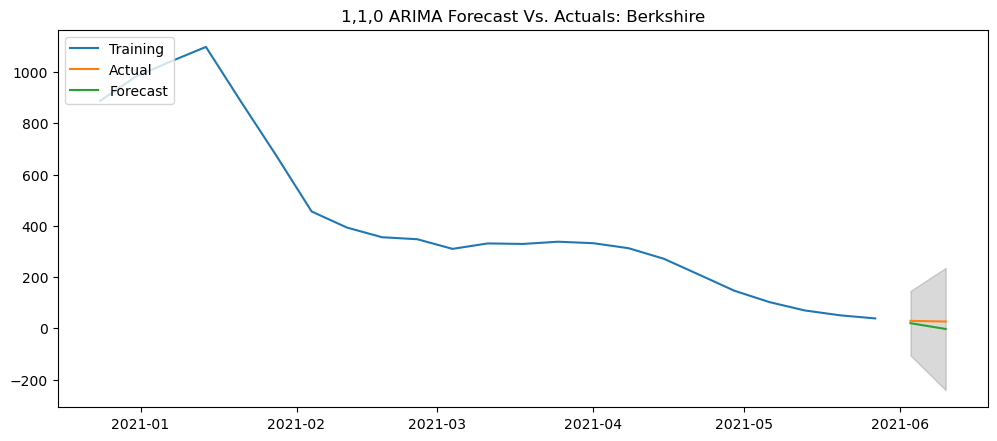

MAPE:  0.7093516844433347 
MAE:  -0.7093516844433347 
ME:  -19.147288296342147 
Correlation:  1.0 
Min-Max:  0.7093516844433349


In [111]:
County_modelling('Berkshire', counties_ARIMA, counties_dict, None, 0.1, True)

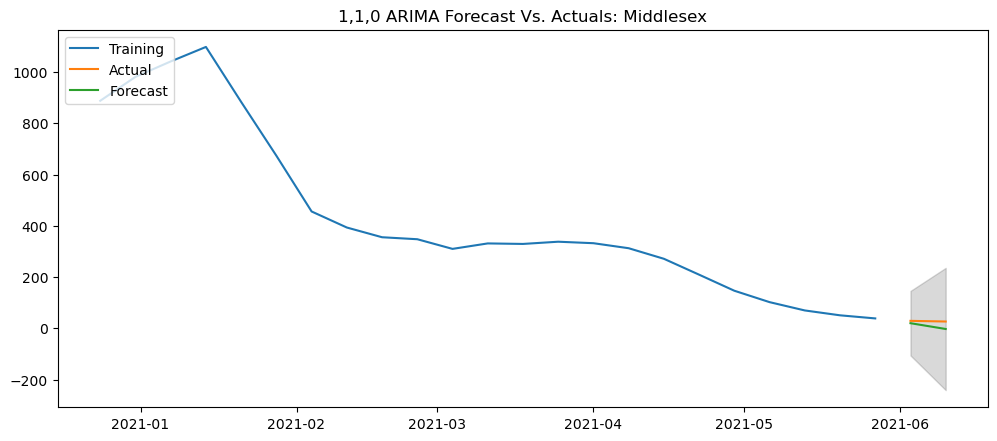

MAPE:  0.7093516844433347 
MAE:  -0.7093516844433347 
ME:  -19.147288296342147 
Correlation:  1.0 
Min-Max:  0.7093516844433349


In [112]:
#fig, ax = plt.subplots()
County_modelling('Middlesex', counties_ARIMA, counties_dict, None, 0.1, True)

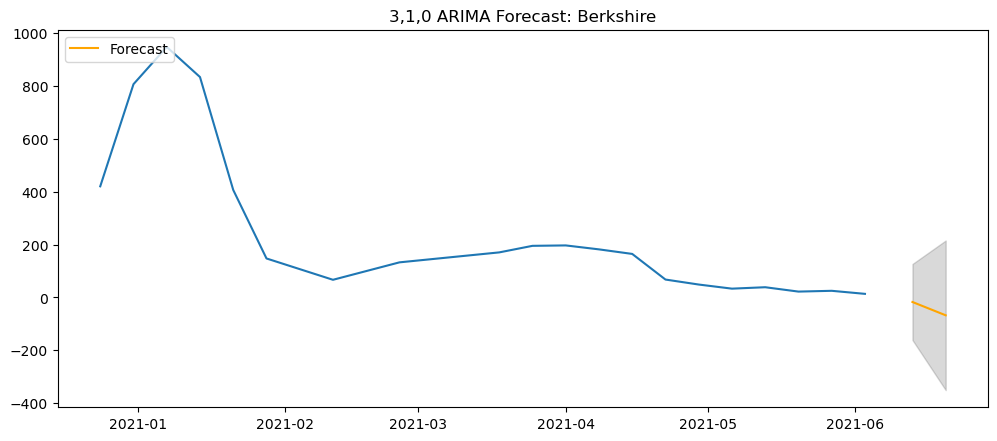

In [106]:
#You can toggle the suppress_plot flag with True/False. 
#Feel free to try out the forecast with different counties. 
County_forecast('Berkshire', counties_ARIMA, counties_dict, None, 0.1, False)

# Modelling Conclusion:
By using a grid-search for the ARIMA parameters, I can yield a more accurate forecast using the normalized concentration data.

But as I am using the wastewater normalized_concentration to forecast the TREND of the percent positivity, the actual numbers may not be the area of interest. Rather it is the slope of that trend line, whether it trends upwards, downwards, or shows no change as a straight line. 

In this case, the out-of-sample forecast is a downward trend, indicating that there might be a downard trend in Percent Positivity as well.